In [1]:
import re
import os
import nltk
import spacy
import string
import pprint
import random
import operator
import powerlaw
import numpy as np
import collections
import pandas as pd
import numpy as np 
import helper2 as h2
import networkx as nx
import seaborn as sns
import pygraphviz as pgv
import matplotlib.cm as cm
from pylab import rcParams
from itertools import count
from itertools import islice
from tabulate import tabulate
from textblob import TextBlob
from nltk.stem.porter import *
from wordcloud import WordCloud
from operator import itemgetter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import matplotlib.colors as mcolors
from numpy.random import default_rng
from matplotlib import pyplot, patches 
from nltk.tokenize import word_tokenize
from timeit import default_timer as timer
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import floyd_warshall, dijkstra
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = PorterStemmer()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yasas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yasas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yasas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\yasas\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [4]:
from spacy.lang.en.stop_words import STOP_WORDS as scipy_stop
from nltk.corpus import stopwords as nltk_stop 
from wordcloud import STOPWORDS as wc_stop

stop_words_list = []
stop_words_list.extend(list(scipy_stop))
stop_words_list.extend(list(nltk_stop.words('english')))
stop_words_list.extend(list(wc_stop))

# List of custom stop words 
custom_stop_words = [
    'well', 'would', 'never', 'latitude', 'longitude', 'wonderland', 'wonder', 'adventure', 'adventures', 'chapter',
    'car','race','great','please', 'maam', 'drink', 'think', 'sink', 'come', 'foot', 'right', 'thats', 'too', 'itll', 
    'tell', 'table', 'long', 'ye', 'let', 'pandavas', 'tale', 'test', 'said', 'held', 'crab', 'next','men', 'sure', 
    'digging', 'i', 'i\'ve', 'oh', 'bills','battle','islandborn', 'number','thou','thy', 'unto','ill', 'im', 'ive',
    'whats', 'read', 'little', 'id',    'look', 'dont', 'luckily', 'get', 'lizard', 'the', 'son', 'addressed', 
    'continued', 'thee', 'viz', 'diademdecked', 'king', 'word','words', 'beholding', 'sons', 'hath', 'great', 'brahmana',
    'kuru', 'hear', 'slay', 'grandsire', 'krishnadwaipayana']

stop_words_list = list(set(stop_words_list))
stop_words_list += custom_stop_words

In [5]:
type(str)

type

In [6]:
def read_file(filename, remove_stop_words = True, preprocess = True, return_type = list):
    """
    This function reads content from given file and does preprocessing
    and stop words removal as decided by the parameters.

    Parameters
    ----------
    filename : str
      Path to the file location

    remove_stop_words : bool 
      A boolean value that dictates if stop words should be removed.

    preprocess : bool
      A boolean value that dictates if preprocessing should be done.
      Characters like carriage return, linefeed, form feed and punctuation 
      will be removed

    return_type : type
       Decides if the return is a list of sentences or a paragraph string
       
    Returns
    ----------
    contents : list or str
       Returns preprocessed contents either as a list of sentences
       or as a whole string which is decided by return_type.
    """
    contents = []
    with open (filename, 'r' , encoding = 'utf-8') as f:
        for l in f:
            line = l.lower().strip()
            if line.strip():
                line = line.replace('\n', ' ').replace('\r', ' ').replace('\'s', '').replace('\'', '')
                if preprocess == True:
                    line = ''.join([char for char in line if char not in string.punctuation]) # Removing Punctuations
                if remove_stop_words == True:
                    line = ' '.join([word for word in line.split() if word.lower() not in stop_words_list])
                for key_name, aliases in h2.same_names_dict.items():
                    for alias in aliases:
                        line = re.sub(r"\b{}\b".format(alias), key_name, line)
                contents.append(line)    
    if return_type == str:
        return ' '.join(contents)
    else:
        return contents

In [7]:
def get_interactions(contents, character_list, N = 15):
    """
    This function outputs a character interaction dictionary - a opmised version of a co-occurance matrix

    Parameters
    ----------
    contents : str
        Paragraph from which character interactions are to be extracted 

    character_list : bool 
        A boolean value that dictates if stop words should be removed.

    N : bool
        Decides the maximum distance(in words) between two character names 
        to consider a valid interaction

    Returns
    ----------
    res : dict
       Dictionary with character pairs as keys and no. of interactions as values
    """
    res = defaultdict(int)
    word_list = contents.split(' ')
    for index, word in enumerate(word_list):
        if word in character_list:
            try:
                interaction_list = word_list[index : index + N + 1]
            except:
                pdb.set_trace()
            for character in character_list:    
                if character!=word:
                    if character in interaction_list:
                        key = tuple(sorted([character, word]))
                        res[key]+=1
    return res

In [8]:
# Co-occurance if interaction is present in 15 words
def get_graph_from_file(contents):    
    """
    This function derives a network using character interaction/ co-occurance dictionary
    based on the contents string provided

    Parameters
    ----------
    contents : str
        Paragraph from which character interactions are to be extracted 
        
    Returns
    ----------
    G : graph
          A NetworkX graph
    """
    
    character_list = h2.all_characters
    res = get_interactions(contents, character_list, N = 15)
    co_occurance_list = list([(*k,v) for (k,v) in res.items()])      
    G=nx.Graph()
    G.add_nodes_from(character_list)
    G.add_weighted_edges_from(co_occurance_list)
    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)
    return G

In [9]:
def get_top_n_central_nodes(centrality_dict, top_n = 5):
    """
    This function returns the top n central nodes along
    with their centrality values 

    Parameters
    ----------
    centrality_dict : dict
        Dictionary with centrality values of characters
    top_n : int
        No of top cental nodes to be returned
    
    Returns
    ----------
    top_nodes : list
          A list of top nodes and their centrality values
    """
    top_nodes =  [str(k) + ': ' + str(round(v, 4)) for k, v in sorted(centrality_dict.items(), key = lambda x : x[1], 
                                                                reverse = True )[:top_n]]
    return top_nodes

def get_top_n_central_nodes_without_values(centrality_dict, top_n = 5):
    """
    This function returns the top n central nodes

    Parameters
    ----------
    centrality_dict : dict
        Dictionary with centrality values of characters
    top_n : int
        No of top cental nodes to be returned
        
    Returns
    ----------
    top_nodes : list
          A list of top nodes without centrality values
    """ 
    top_nodes =  [str(k) for k, v in sorted(centrality_dict.items(), key = lambda x : x[1], reverse = True )[:top_n]]
    return top_nodes
    

def get_central_actors(G, top_n = 5, with_values = False):
    """
    This function gets the list of top n central nodes using 
    various centrality measures 
    Parameters
    ----------
    G : graph
          A NetworkX graph
    top_n : int
        No of top cental nodes to be returned
    with_values : bool
        A boolean value that decides if the centrality values should also 
        be displayed        
    """ 
    
    numbers = range(1, top_n+1)
    centralities = ['#', 'Betweenness', 'Degree', 'Pagerank', 'closeness']
    eig_dict = nx.eigenvector_centrality(G)
    deg_dict = nx.degree_centrality(G)
    pag_dict = nx.pagerank(G)
    bet_dict = nx.betweenness_centrality(G)
    close_dict = nx.closeness_centrality(G)
    if with_values == True:
        bet_top = get_top_n_central_nodes(bet_dict, top_n)
        deg_top = get_top_n_central_nodes(deg_dict, top_n)
        pag_top = get_top_n_central_nodes(pag_dict, top_n) 
        close_top = get_top_n_central_nodes(close_dict, top_n)    
        print(tabulate(np.c_[numbers, bet_top ,deg_top, pag_top, close_top], headers = centralities))
    else:
        bet_top = get_top_n_central_nodes_without_values(bet_dict, top_n)
        deg_top = get_top_n_central_nodes_without_values(deg_dict, top_n)
        pag_top = get_top_n_central_nodes_without_values(pag_dict, top_n) 
    #     eig_top = get_top_n_central_nodes(eig_dict, top_n)    
        close_top = get_top_n_central_nodes_without_values(close_dict, top_n)    
        print(tabulate(np.c_[numbers, bet_top ,deg_top, pag_top, close_top], headers = centralities))

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

In [10]:
filepath = r"E:\Social Networks and Text Analytics\CA2\Mahabharata\Mahabharata-K.M.Ganguli.txt"

In [11]:
contents = read_file(filepath, remove_stop_words = True, preprocess = True, return_type = str)    
Gx = get_graph_from_file(contents)

#### Let us look at the basic statistics of the Graph that we have just created

In [12]:
print(f"No of actors(nodes) in the Graph are {len(Gx.nodes)}")
print(f"No of ties(edges) in the Graph are {len(Gx.edges)}")
print(f"Avg Shortest Path Length is {nx.average_shortest_path_length(Gx)}")
print(f"Avg Clustering Coefficient is {nx.average_clustering(Gx)}")
print(f"Transitivity of the Graph is {nx.transitivity(Gx)}")
print(f"Avg Node Connectivity is {nx.average_node_connectivity(Gx)}")
print(f"Max. distance b/w any pair of nodes (Diameter) is {nx.diameter(Gx)}")
print(f"Radius of the Graph is {nx.radius(Gx)}")

No of actors(nodes) in the Graph are 154
No of ties(edges) in the Graph are 2728
Avg Shortest Path Length is 1.8354978354978355
Avg Clustering Coefficient is 0.6742193417994761
Transitivity of the Graph is 0.5279993758411515
Avg Node Connectivity is 19.93472540531364
Max. distance b/w any pair of nodes (Diameter) is 4
Radius of the Graph is 2


In [13]:
n = 10
get_central_actors(Gx, top_n = n, with_values = False)

  #  Betweenness    Degree        Pagerank       closeness
---  -------------  ------------  -------------  ------------
  1  krishna        krishna       krishna        krishna
  2  yudhishthira   yudhishthira  arjuna         yudhishthira
  3  arjuna         arjuna        yudhishthira   arjuna
  4  karna          bhima         bhima          bhima
  5  bhima          duryodhana    drona          duryodhana
  6  duryodhana     karna         karna          karna
  7  vaisampayana   bhishma       bhishma        bhishma
  8  bhishma        kunti         duryodhana     kunti
  9  kunti          drona         dhritarashtra  drona
 10  drona          vaisampayana  vaisampayana   vaisampayana


In [14]:
# def draw(G, pos, measure, measure_name, color):
#     """
#     This function draws a network based on a specific metric in the color and a specified layout

#     Parameters
#     ----------
#     G : graph
#       A NetworkX graph

#     pos : dictionary, 
#       A dictionary with nodes as keys and positions as values.

#     measure : dictionary
#       Results of the centrality measure

#     measure_name: str
#        Name of the centrality measure used 
#     """

#     # Get the influencer node from measure
#     influencer_node_index = max(enumerate(measure.values()), key = operator.itemgetter(1))[0]
#     influencer_node  = list(measure.keys())[influencer_node_index]

#     # Plot the graph
#     plt.figure(figsize=(180, 180))
#     # Draw the nodes
#     nodes = nx.draw_networkx_nodes(G, pos, node_size = np.array(list(measure.values()))*80000, cmap = color,
#                                    node_color = np.array(list(measure.values()))*80000, 
#                                    nodelist = list(measure.keys()), alpha = 0.4) 
#     # Draw Influencer Node with size = 800
# #     nx.draw_networkx_nodes(G, pos, node_size = 800, node_color = 'darkGreen', nodelist= [influencer_node]) 
    
#     # Draw the edges
#     edges = nx.draw_networkx_edges(G, pos, edge_color = 'gray', alpha = 0.3)
#     # Draw label only for the influencer node
# #     nx.draw_networkx_labels(G, pos, font_size = 40, labels = {influencer_node: str(influencer_node)},font_color = 'red')
#     nx.draw_networkx_labels(G, pos, font_size = 130, font_color = 'black')
#     plt.title(measure_name, size = 80, weight = 'bold')
#     plt.axis('off')
#     plt.tight_layout()
#     plt.savefig('network_visualisation.jpg')
# #     plt.show()

In [15]:
# page_rank = nx.degree_centrality(Gx)
# page_rank_results = dict(sorted(page_rank.items(), key = lambda item: item[1], reverse = True))
# pos = nx.spring_layout(Gx, k = 3)
# draw(Gx, pos, page_rank_results, 'Degree Centrality', plt.cm.Reds)

In [16]:
# page_rank = nx.pagerank(Gx, alpha = 0.85)
# page_rank_results = dict(sorted(page_rank.items(), key = lambda item: item[1], reverse = True))
# pos = nx.spring_layout(Gx, k = 2)
# draw(Gx, pos, page_rank_results, 'Page Rank Centrality', plt.cm.Reds )

### Calculate and plot Ego network of top 15 characters in the Epic

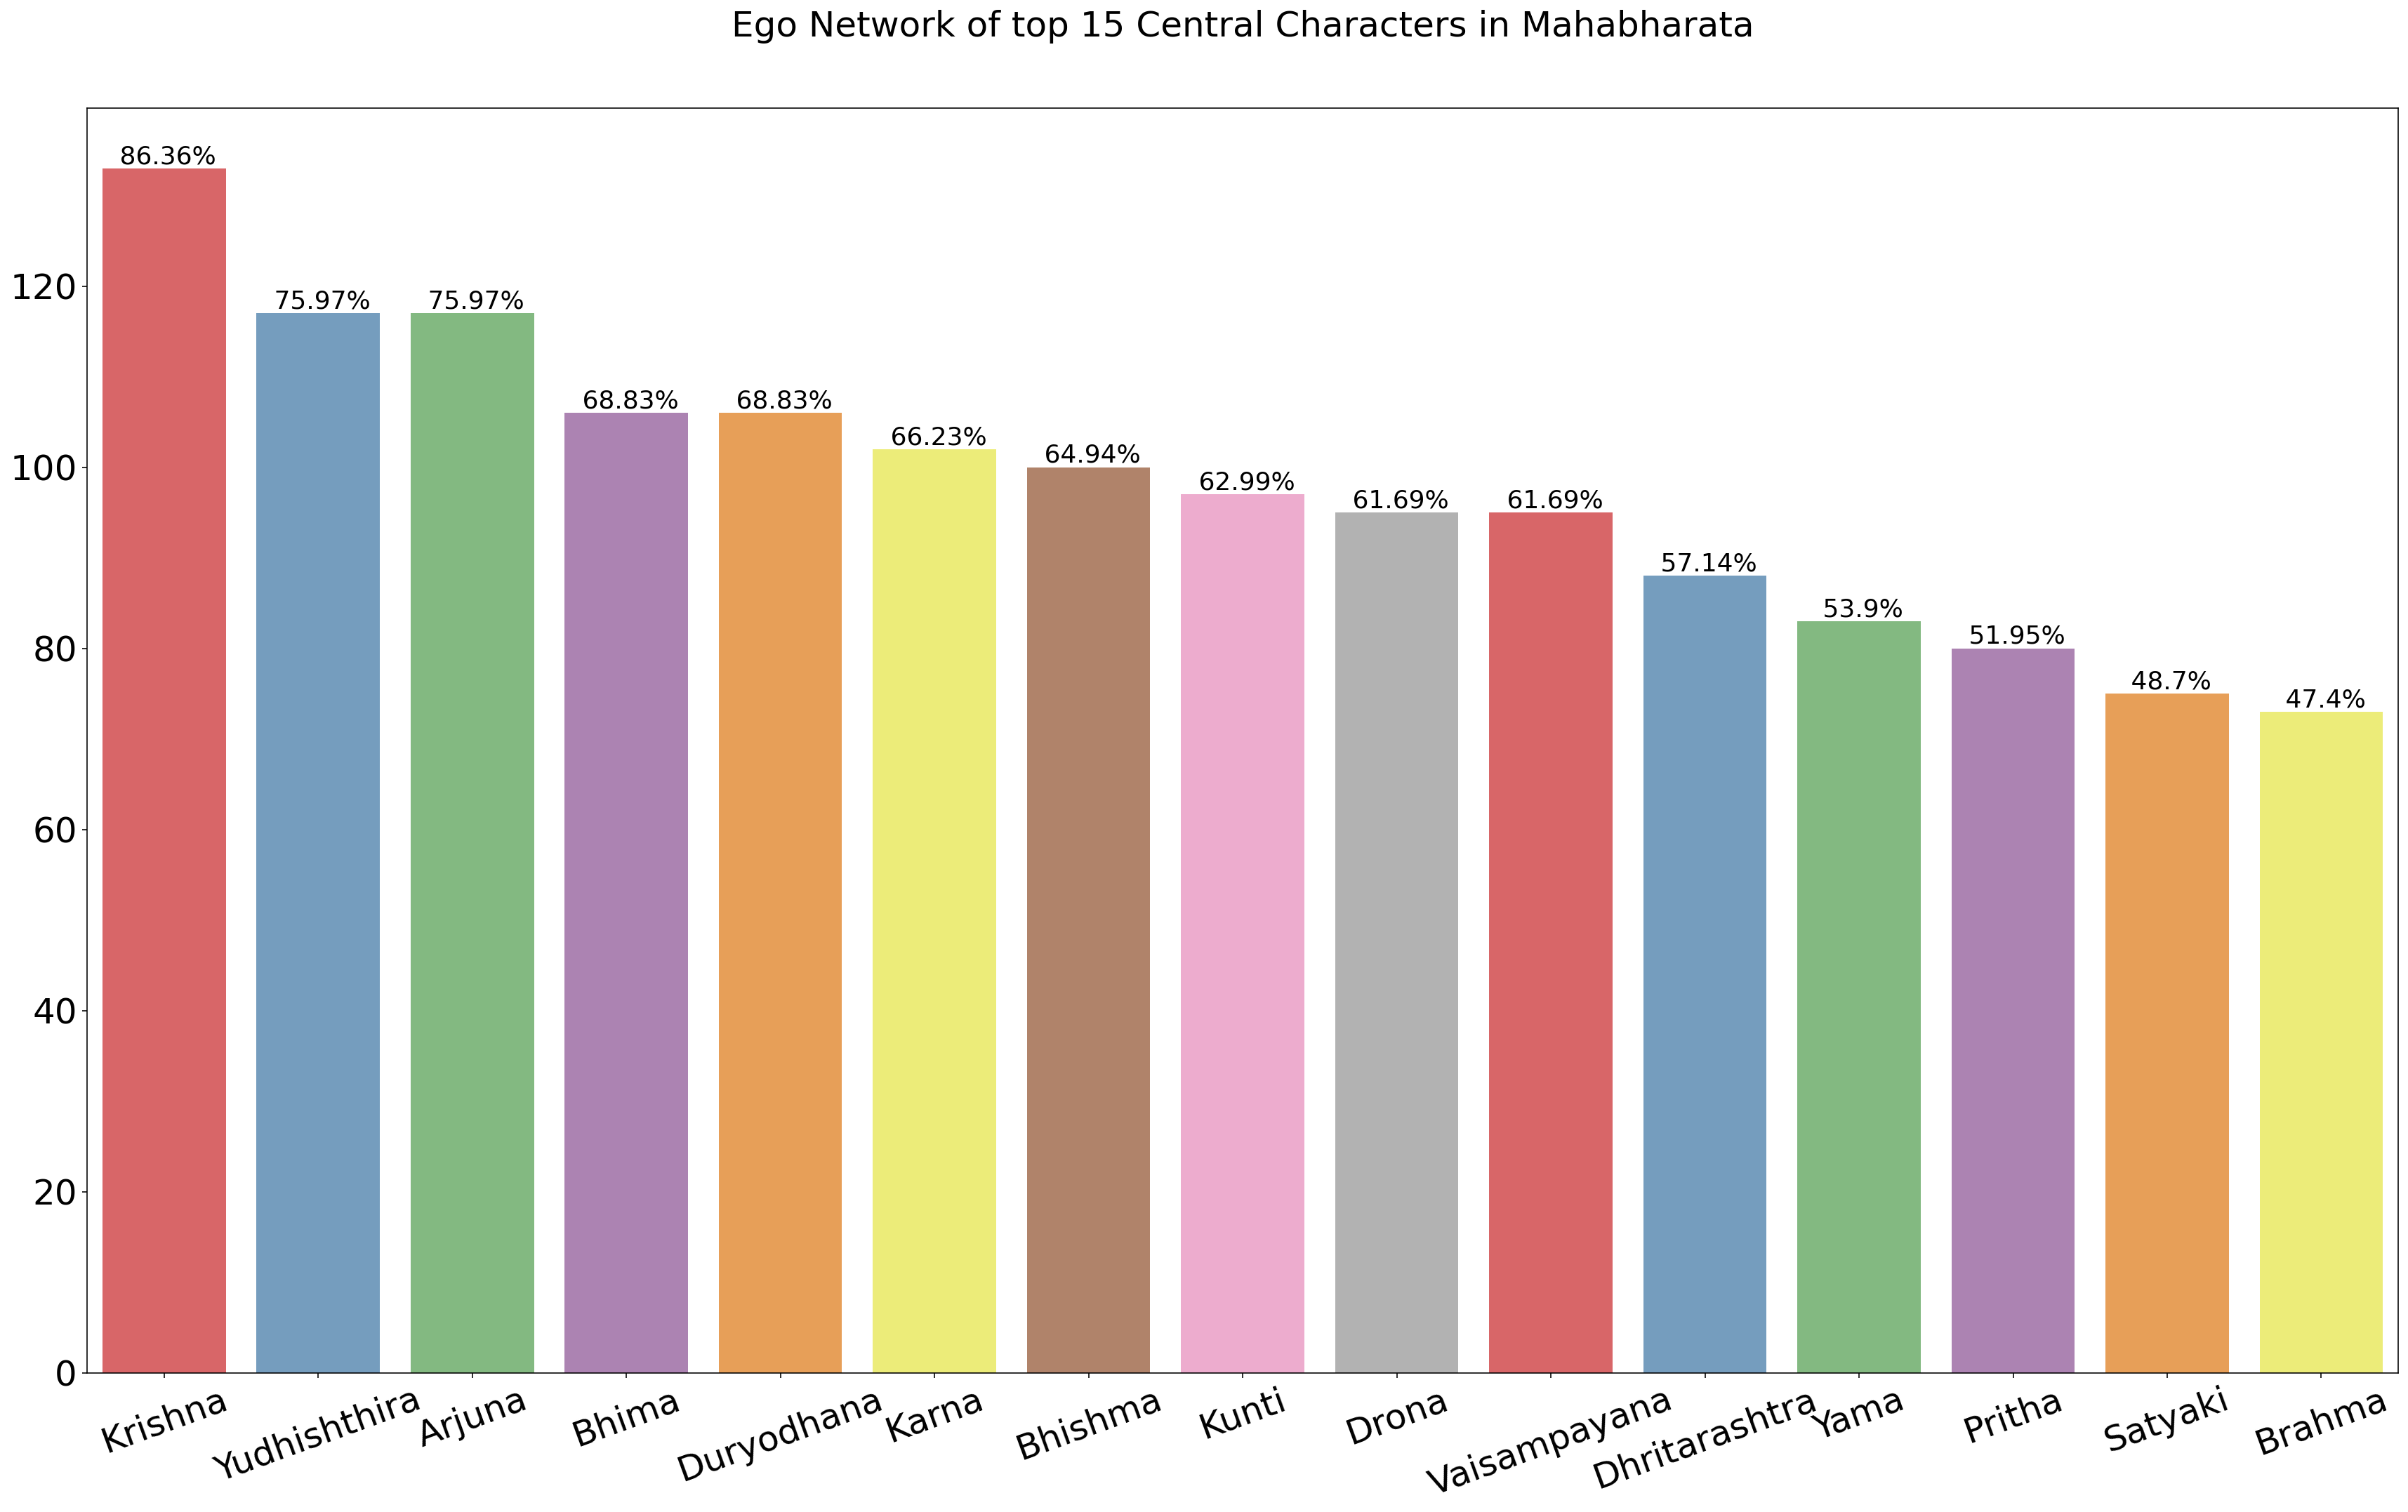

In [17]:
def plot_influencers(G, N = 10):
    """
    This function plots the top-n influencers in a bar chart 
    Parameters
    ----------
    G : graph
          A NetworkX graph
    N : int
        No of influencers to be plotted
    """    
    influence_dict = defaultdict(float)
    for char in h2.all_characters:
        if char in G.nodes:
            influence_dict[char] = len(nx.ego_graph(G, n = char, radius = 1).nodes)
    influence_dict = {k: v for k, v in sorted(influence_dict.items(), key=lambda item: item[1], reverse = True)}
    plt.figure(figsize = (24, 15))
    top_influences = take(N, influence_dict.items())
    keys = [x.title() for x in top_influences.keys()]
    vals = [top_influences[k.lower()] for k in keys]
    percent = [round(float(top_influences[k.lower()]/len(influence_dict.keys()))*100,2) for k in keys]
    labels = [f"{str(vals[i])} ({str(percent[i])}%)" for i in range(len(vals))]
    labels = [f" {str(percent[i])}%" for i in range(len(vals))]

    g = sns.barplot(x=keys, y=vals,palette = "Set1", alpha = 0.75)
    g.bar_label(g.containers[0], labels = labels, size = 18)
    g.tick_params(axis='x', which = 'major', labelsize = 25, rotation = 20)
    g.tick_params(axis='y', which = 'major', labelsize = 25)
    
    plt.title('Ego Network of top 15 Central Characters in Mahabharata', size = 25, y = 1.05)
    plt.tight_layout()
    plt.savefig('ganguly_influencers.jpg')
    plt.show()

plot_influencers(Gx, 15)

<ipython-input-18-8406f523c4e6>:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


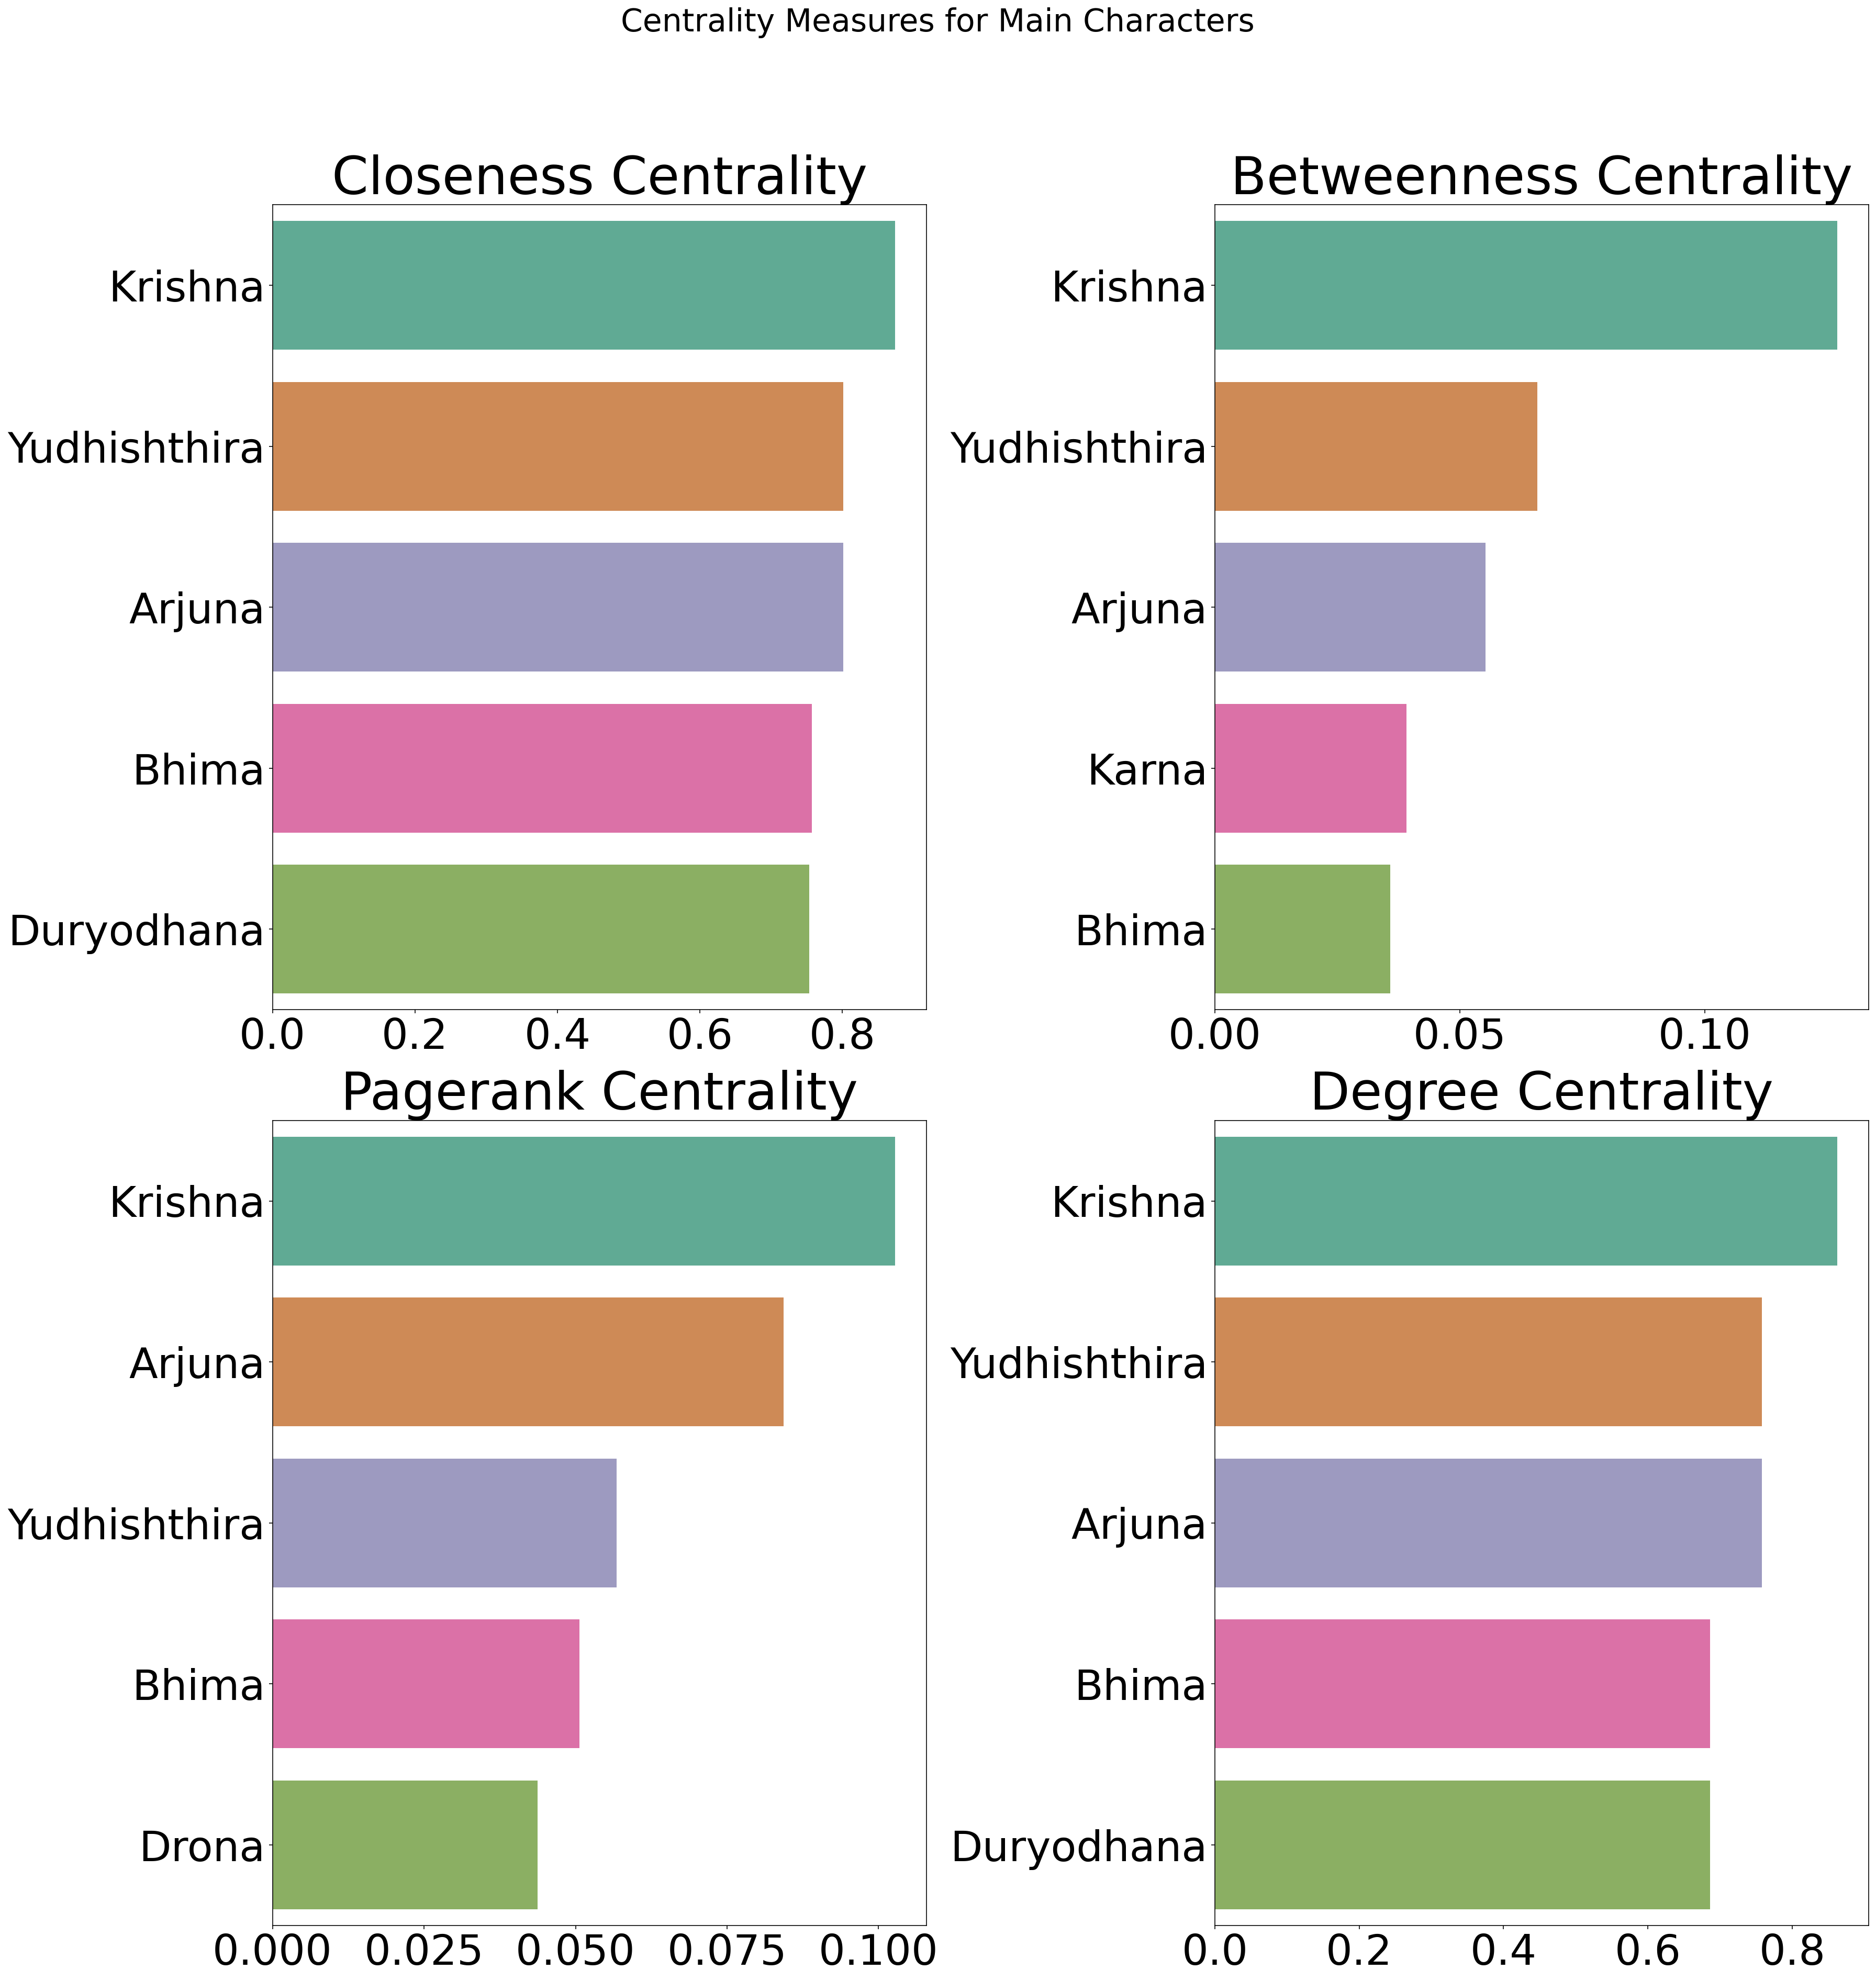

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

In [18]:
def plot_centrality(G, N = 15):
    """
    This function gets the list of top n central nodes using 
    various centrality measures 
    Parameters
    ----------
    G : graph
          A NetworkX graph
    N : int
        No of influencers to be plotted
    """   
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(25, 25))
    fig.suptitle('Centrality Measures for Main Characters', size = 30, y = 1.05 )
    ax = axes.flatten()
    measures = [['Closeness Centrality', nx.closeness_centrality], 
                ['Betweenness Centrality', nx.betweenness_centrality],
                ['Pagerank Centrality', nx.pagerank], 
                ['Degree Centrality',nx.degree_centrality]]
    for i in range(len(measures)):
        ax[i].set_title(measures[i][0], size = 50)
        centrality_dict = measures[i][1](G)
        centrality_dict = {k: v for k, v in sorted(centrality_dict.items(), key=lambda item: item[1], reverse = True)}
        plt.figure(figsize = (24, 9))
        top_influences = take(N, centrality_dict.items())
        keys = [x.title() for x in top_influences.keys()]
        vals = [top_influences[k.lower()] for k in keys]
        g = sns.barplot(y=keys, x=vals , palette = "Dark2", alpha = 0.75, ax = ax[i])
#         g.set_yticklabels(keys, size = 15)
        g.tick_params(axis='both', which='major', labelsize = 40)

#         g.set_xticklabels(g.get_xticks()[::2], size = 15)
#         g.set_xticklabels([str(i) for i in g.get_xticks()], fontsize = 15)

    fig.tight_layout()
    fig.savefig('ganguly_central_characters.jpg', )
    fig.show()

plot_centrality(Gx, N = 5)

In [19]:
file_mb_summary_1 = r"E:\Social Networks and Text Analytics\CA2\Mahabharata\Mahabharata-C.Rajagopalachari.txt"
file_mb_summary_2 = r"E:\Social Networks and Text Analytics\CA2\Mahabharata\Mahabharata-R.K.Narayan.txt"
file_mb_full_1 = r"E:\Social Networks and Text Analytics\CA2\Mahabharata\Mahabharata-K.M.Ganguli.txt"
file_mb_full_2 = r"E:\Social Networks and Text Analytics\CA2\Mahabharata\Mahabharata-Bibek_Debroy.txt"

In [20]:
mahabharata_sentences = read_file(file_mb_full_1, remove_stop_words = True, return_type = list)

In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_word(word):
    """
    This function returns the lemmatized word based on pos-tagging
    Parameters
    ----------
    word : str
          word to be lemmatized
    
    Returns
    ----------
    lem_token : str
          lemmatized word
    """ 
    lemmatizer = WordNetLemmatizer()
    lem_token = lemmatizer.lemmatize(word, pos=wordnet.NOUN)
    # otherwise check for verb
    if lem_token == word:
        lem_token = lemmatizer.lemmatize(word, pos=wordnet.VERB)
    # otherwise check for adjective
    if lem_token == word:
        lem_token = lemmatizer.lemmatize(word, pos=wordnet.ADJ)
    # otherwiese check for adverb
    if lem_token == word:
        lem_token = lemmatizer.lemmatize(word, pos=wordnet.ADV)
    return lem_token

#### Let us plot word clouds to find out words which describe our top central characters

In [22]:
main_characters = ['krishna', 'arjuna', 'yudhishthira', 'duryodhana']

In [23]:
# Extract all the sentences where the name of each character is mentioned
character_related_sentences = defaultdict(list)
for index,sentence in enumerate(mahabharata_sentences):
    sentence = ' '.join([lemmatize_word(w) for w in sentence.split()])
    for character in main_characters:
        if character in sentence:
                character_related_sentences[character].append(sentence)
#                 character_related_sentences[character].append(mahabharata_sentences[index+1])
#                 character_related_sentences[character].append(mahabharata_sentences[index+2])
    character_related_sentences[character] = list(set(character_related_sentences[character]))

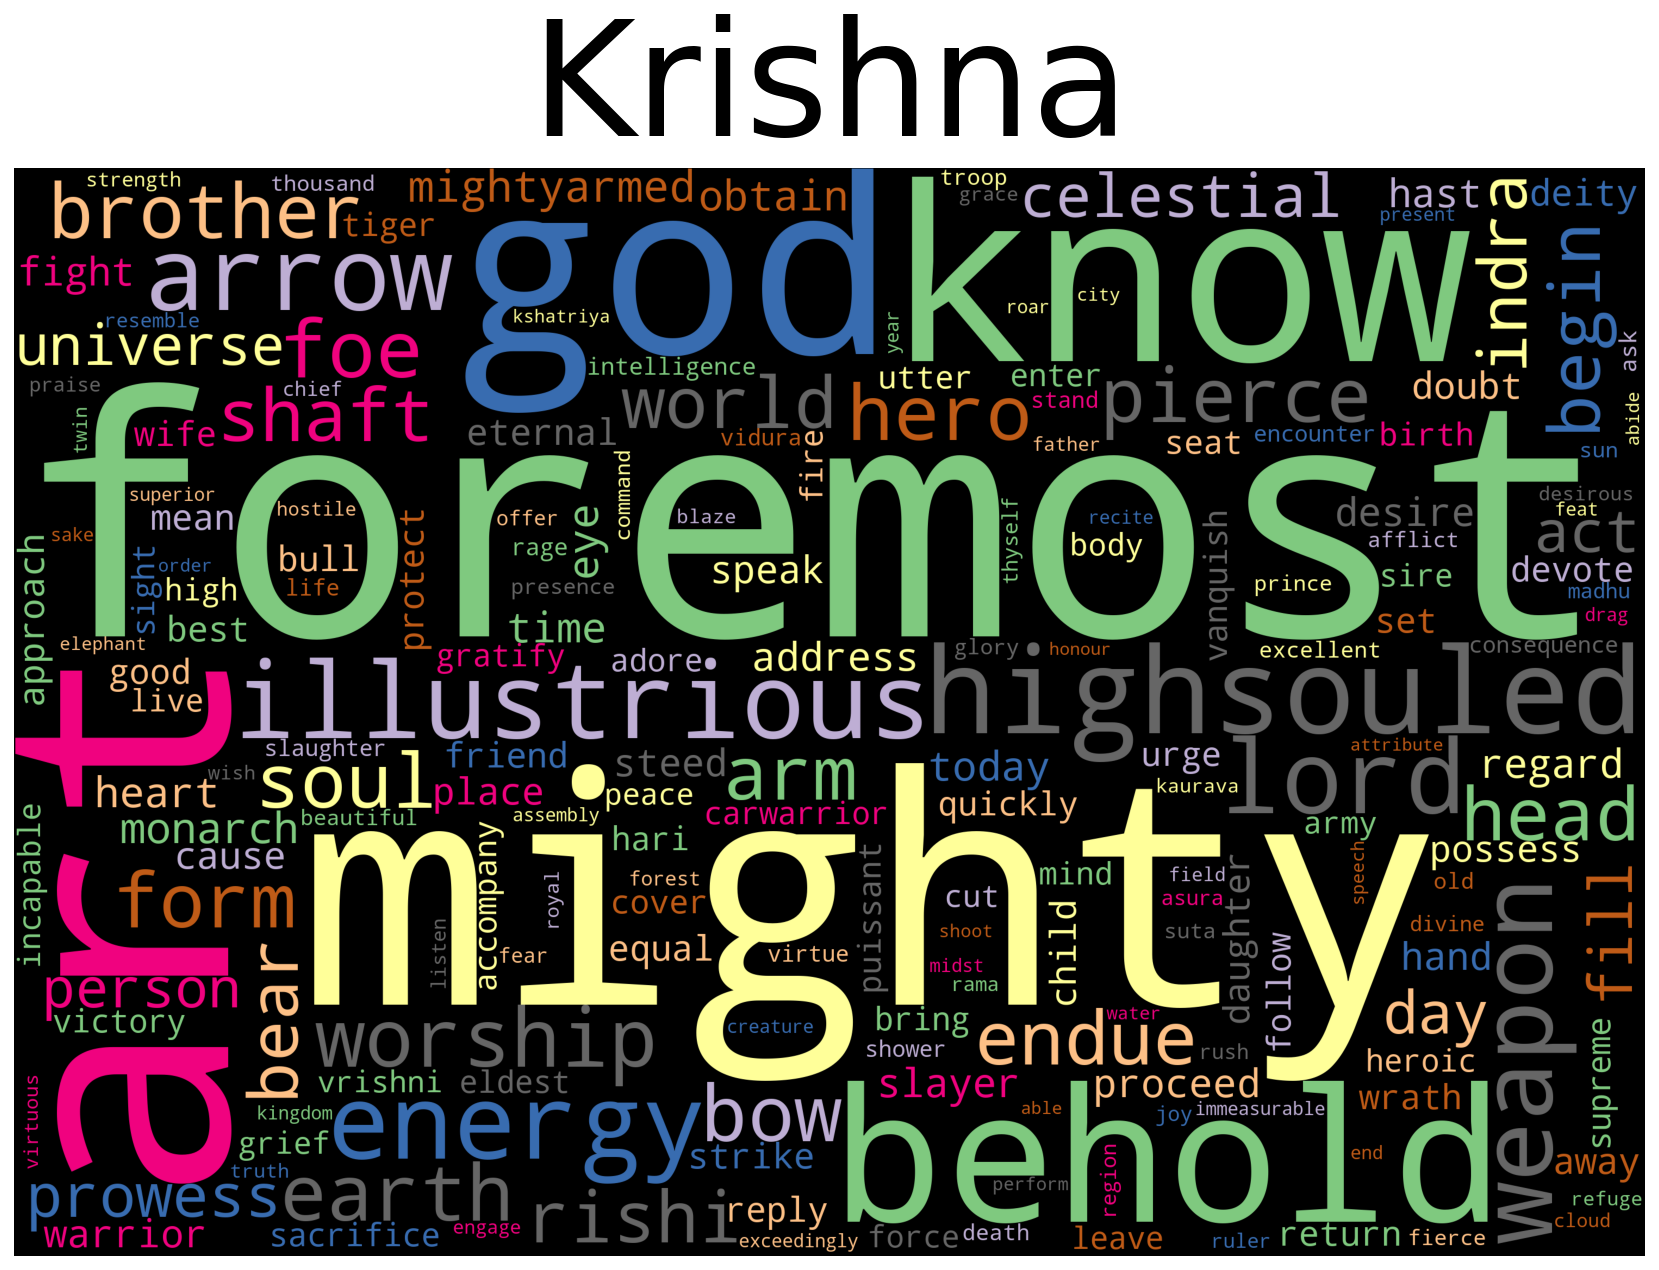

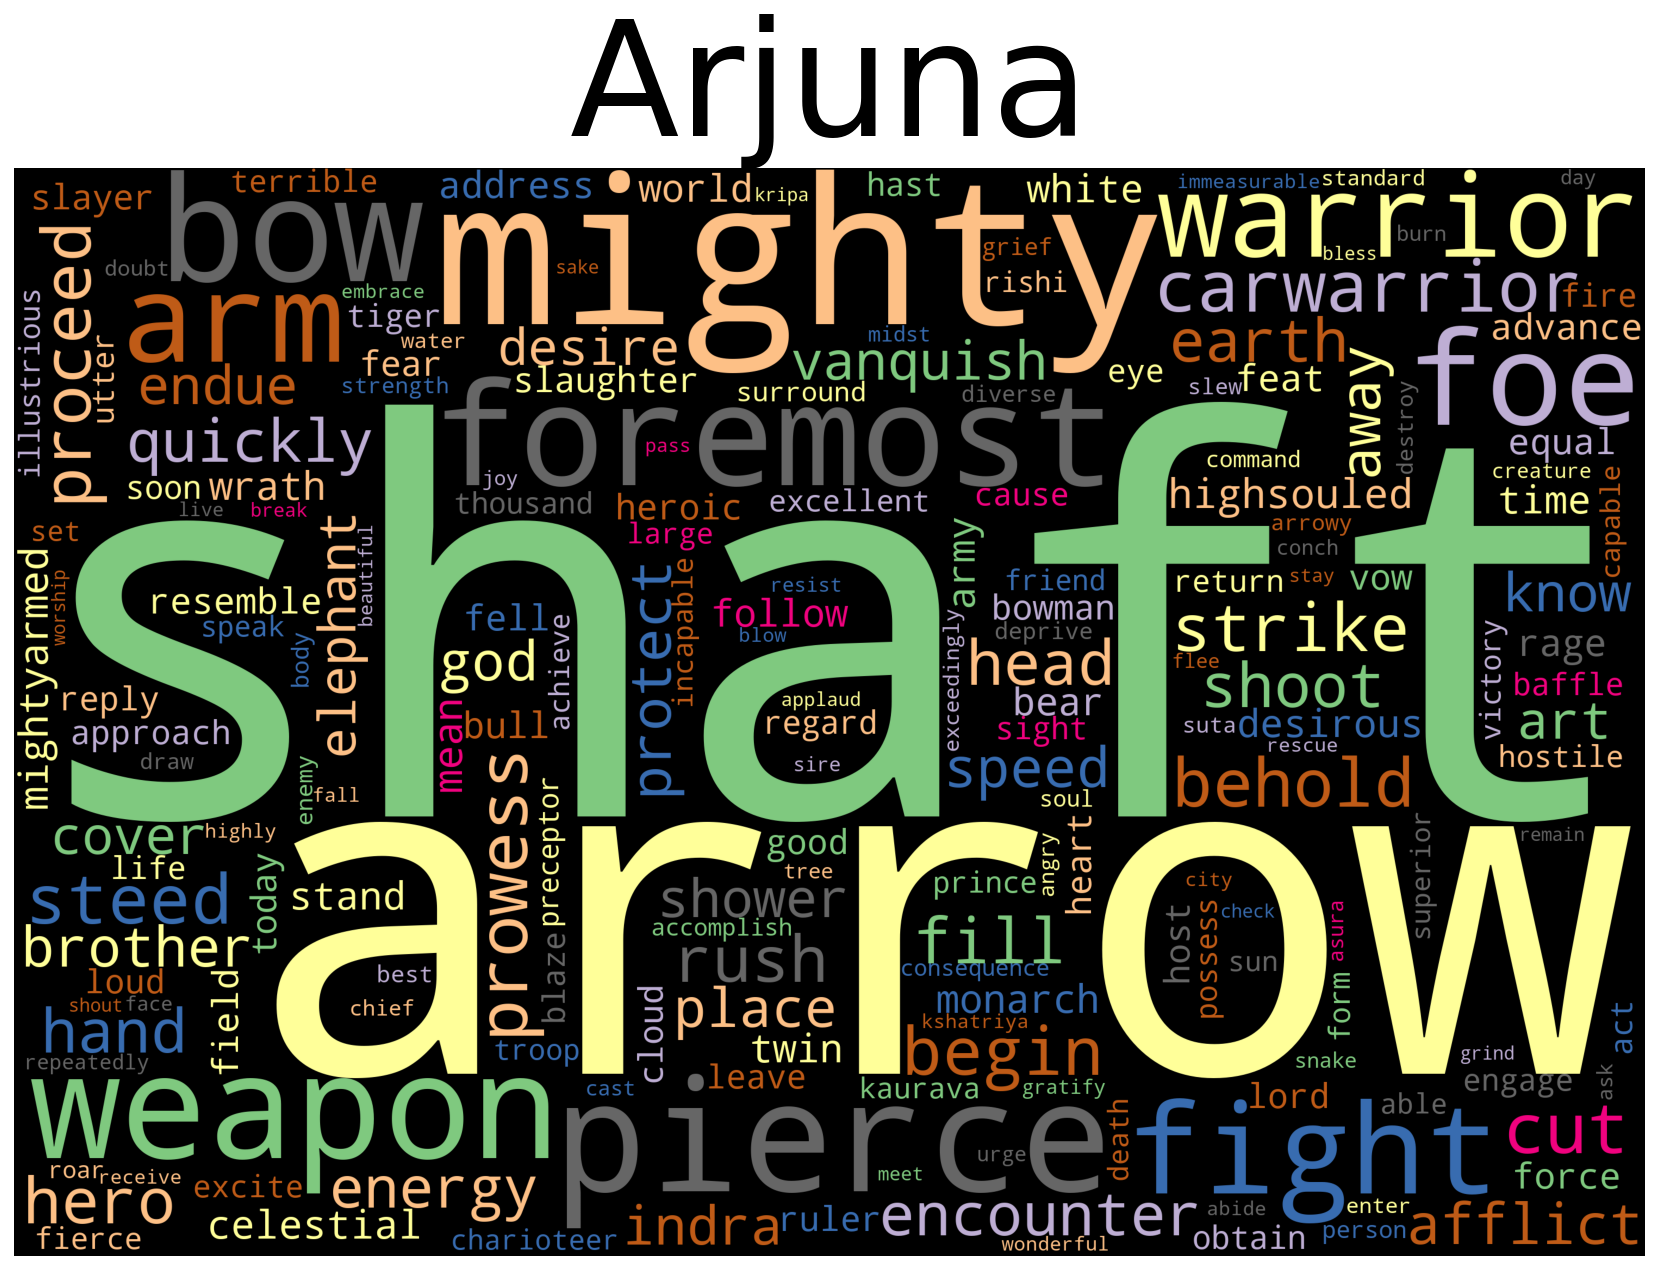

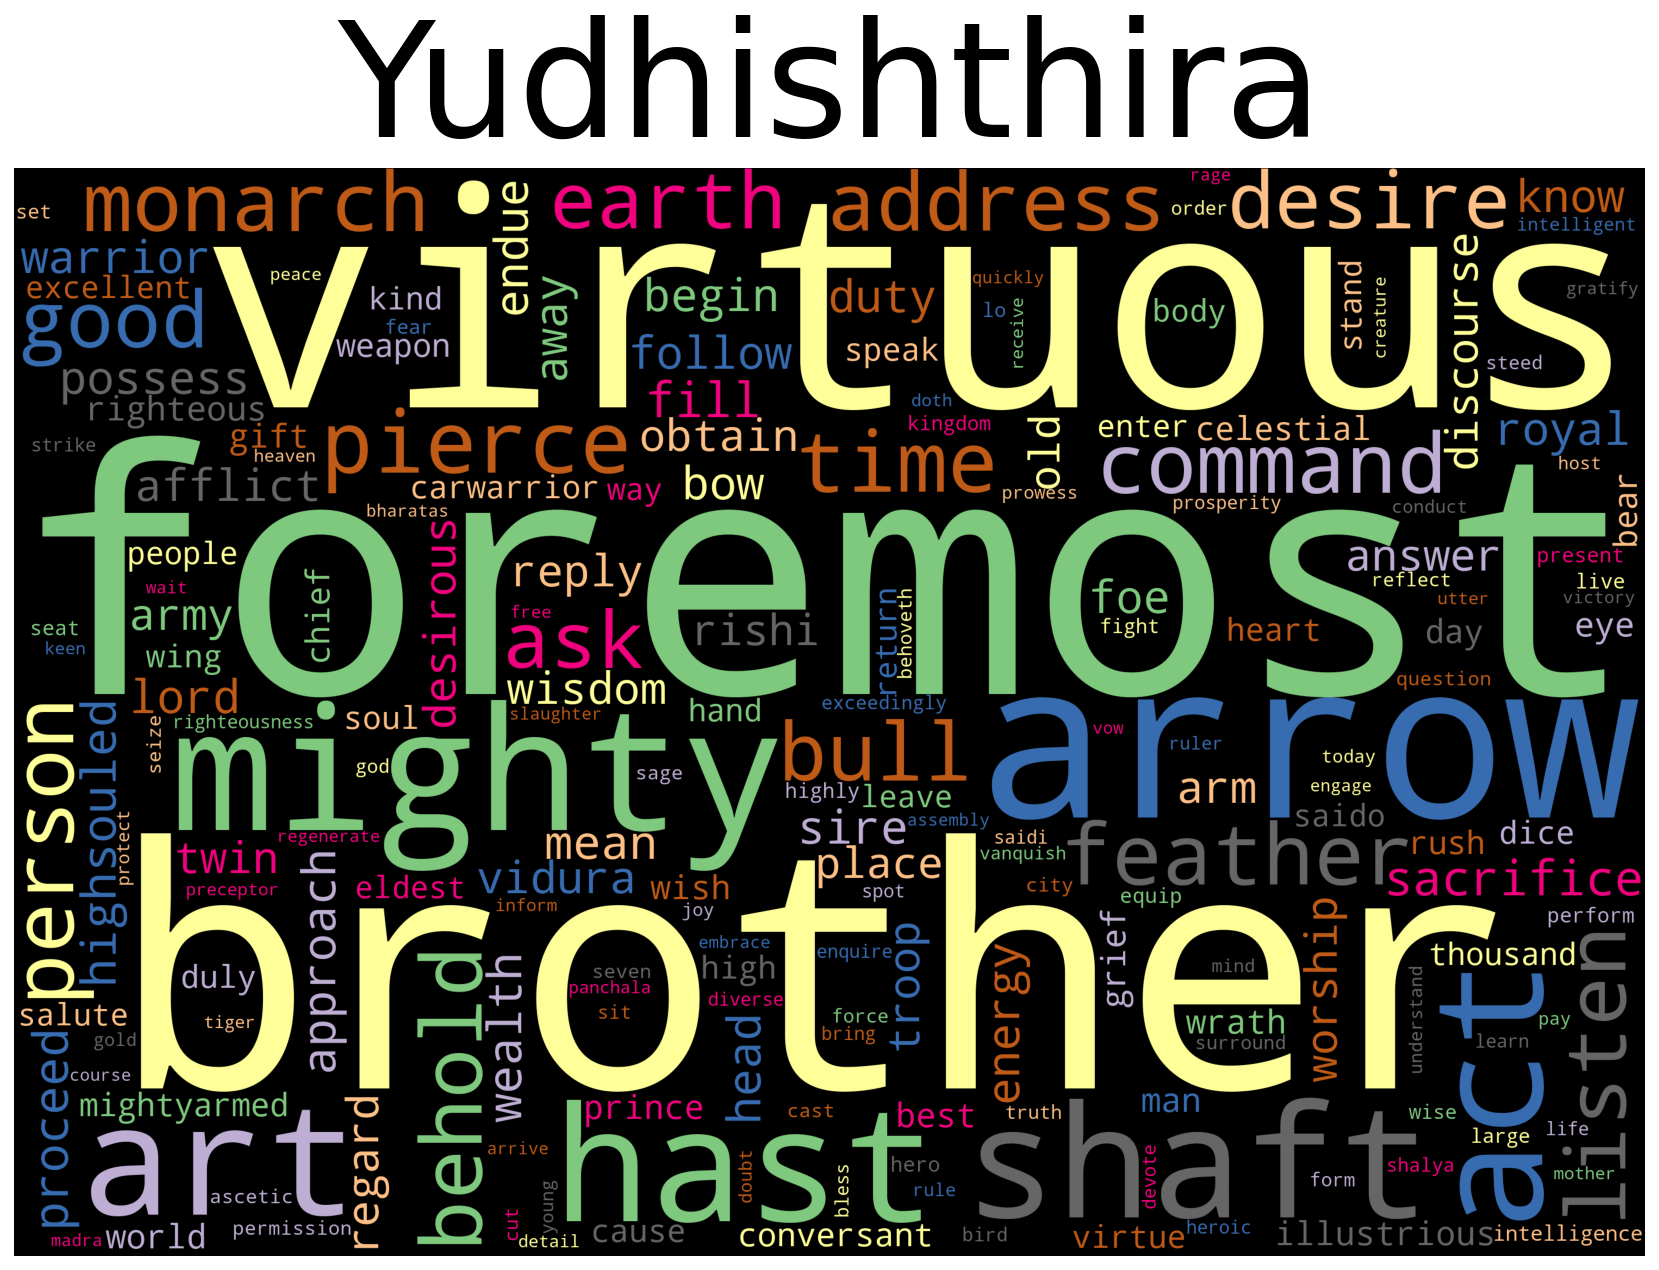

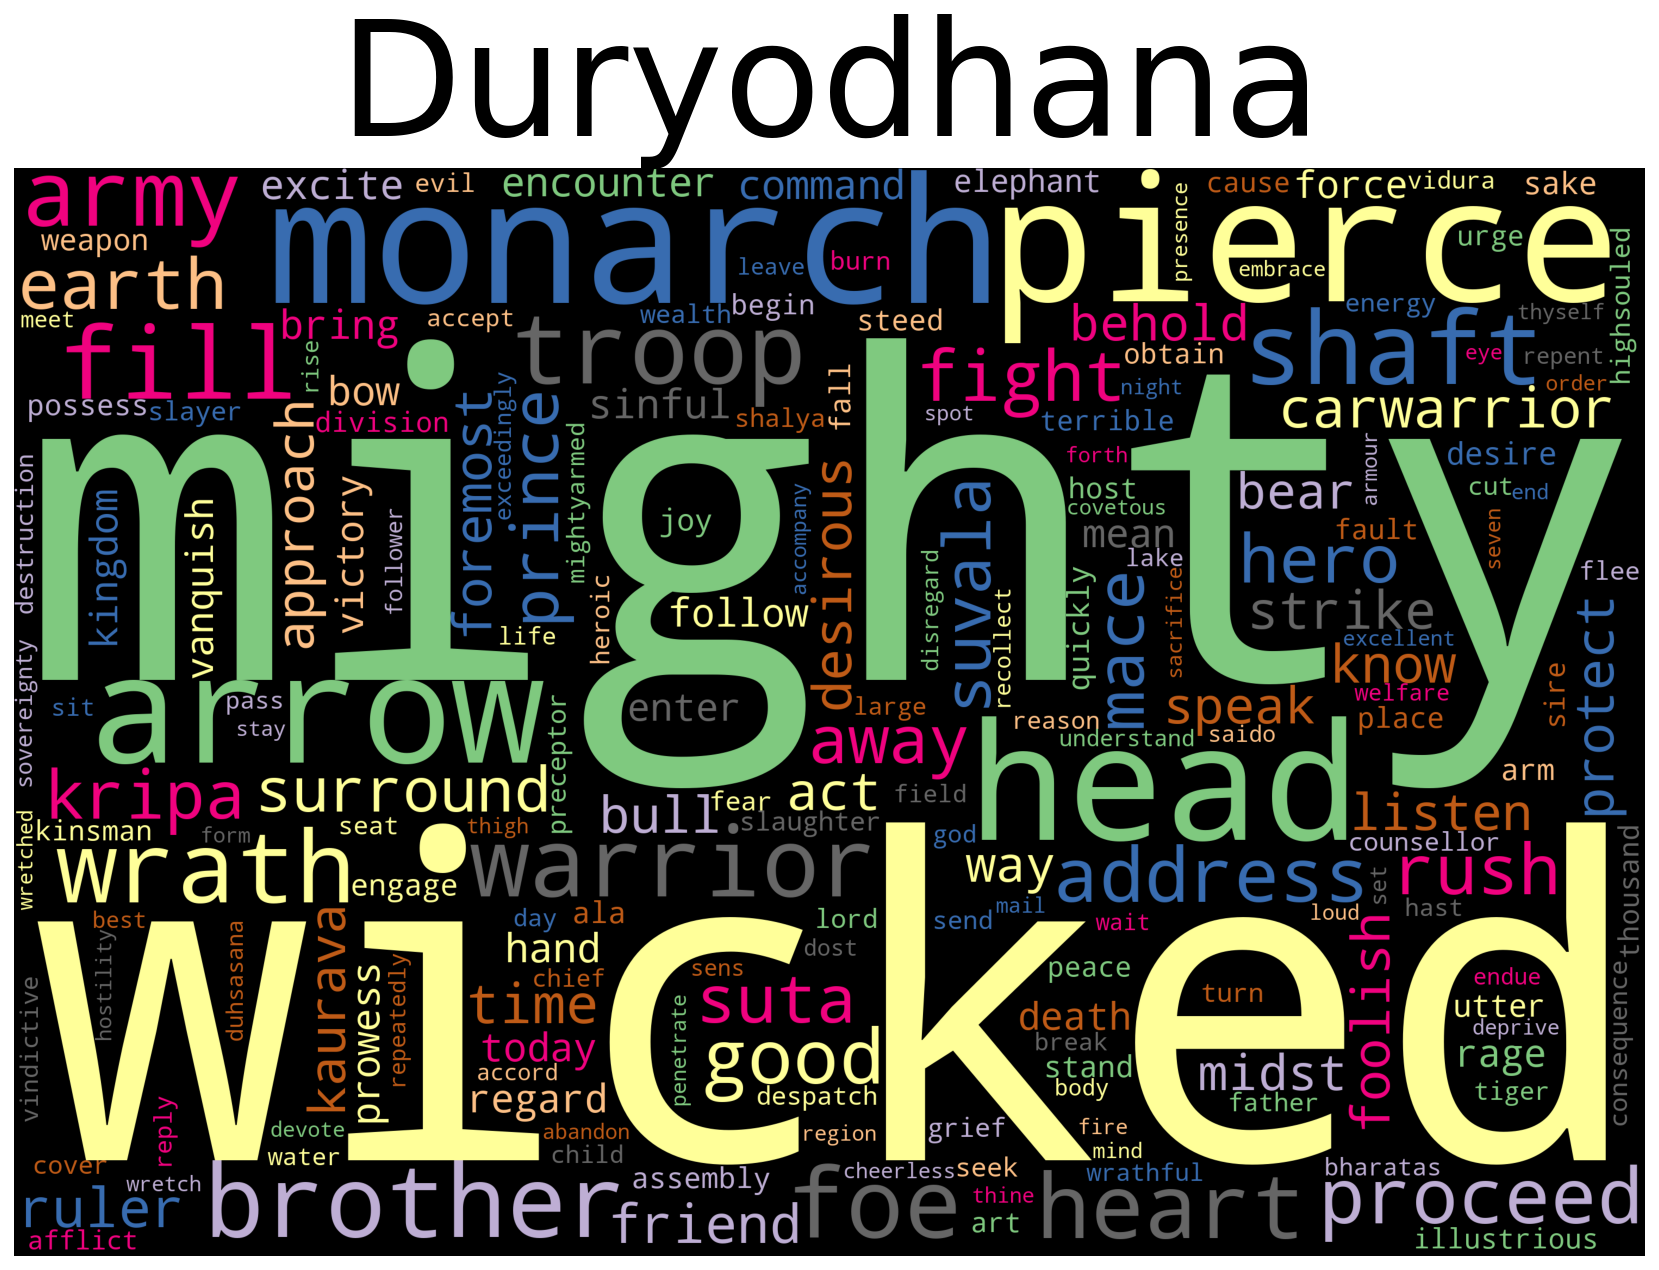

In [24]:
def plot_wordclouds(character_related_sentences, main_characters):
    """
    This function plots word clouds of main characters
    Parameters
    ----------
    character_related_sentences : dict
          dictionary with keys as names of characters and values as list of sentences where the name
          of the character is mentioned
    main_characters : list
          characters of interest whose words clouds are to be plotted
    """ 
    for character in main_characters:
        character_str = ' '.join(character_related_sentences[character])
        wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
                      background_color='black', colormap='Accent', 
                      collocations=False, stopwords = stop_words_list + h2.all_characters_unedited 
                              + h2.all_characters + custom_stop_words).generate(character_str)
        plt.figure(figsize=(15, 10))
        plt.imshow(wordcloud) 
        plt.axis("off")
        plt.savefig(f"Word Cloud {character}.jpg")
        plt.title(character.title(), size = 80)
        plt.show()
        
plot_wordclouds(character_related_sentences, main_characters)

# Text Similarity Analysis

### Similarity between various translations

In [25]:
# Read four various translations of the epic in str and list formats
mb_summary_1_list = read_file(file_mb_summary_1, preprocess = True, remove_stop_words = True, return_type = list)
mb_summary_2_list = read_file(file_mb_summary_2, preprocess = True, remove_stop_words = True, return_type = list)
mb_full_1_list = read_file(file_mb_full_1, preprocess = True, remove_stop_words = True, return_type = list)
mb_full_2_list = read_file(file_mb_full_2, preprocess = True, remove_stop_words = True, return_type = list)

mb_summary_1_str = read_file(file_mb_summary_1, preprocess = True, remove_stop_words = True, return_type = str)
mb_summary_2_str = read_file(file_mb_summary_2, preprocess = True, remove_stop_words = True, return_type = str)
mb_full_1_str = read_file(file_mb_full_1, preprocess = True, remove_stop_words = True, return_type = str)
mb_full_2_str = read_file(file_mb_full_2, preprocess = True, remove_stop_words = True, return_type = str)

In [26]:
# Print the similarity matrix that depicts similarities between all the translations
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform([mb_full_1_str, mb_full_2_str, mb_summary_1_str, mb_summary_2_str])
similarity = np.round(cosine_similarity(tfidf),2)
numbers = ['Full T1', 'Full T2', 'Summary T1', 'Summary T2']
centralities = ['Book', 'Full T1', 'Full T2', 'Summary T1', 'Summary T2']
print(tabulate(*[np.c_[numbers, similarity*100]], headers = centralities))

Book          Full T1    Full T2    Summary T1    Summary T2
----------  ---------  ---------  ------------  ------------
Full T1           100         62            62            44
Full T2            62        100            58            42
Summary T1         62         58           100            63
Summary T2         44         42            63           100


<ipython-input-27-af5290c7bd40>:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


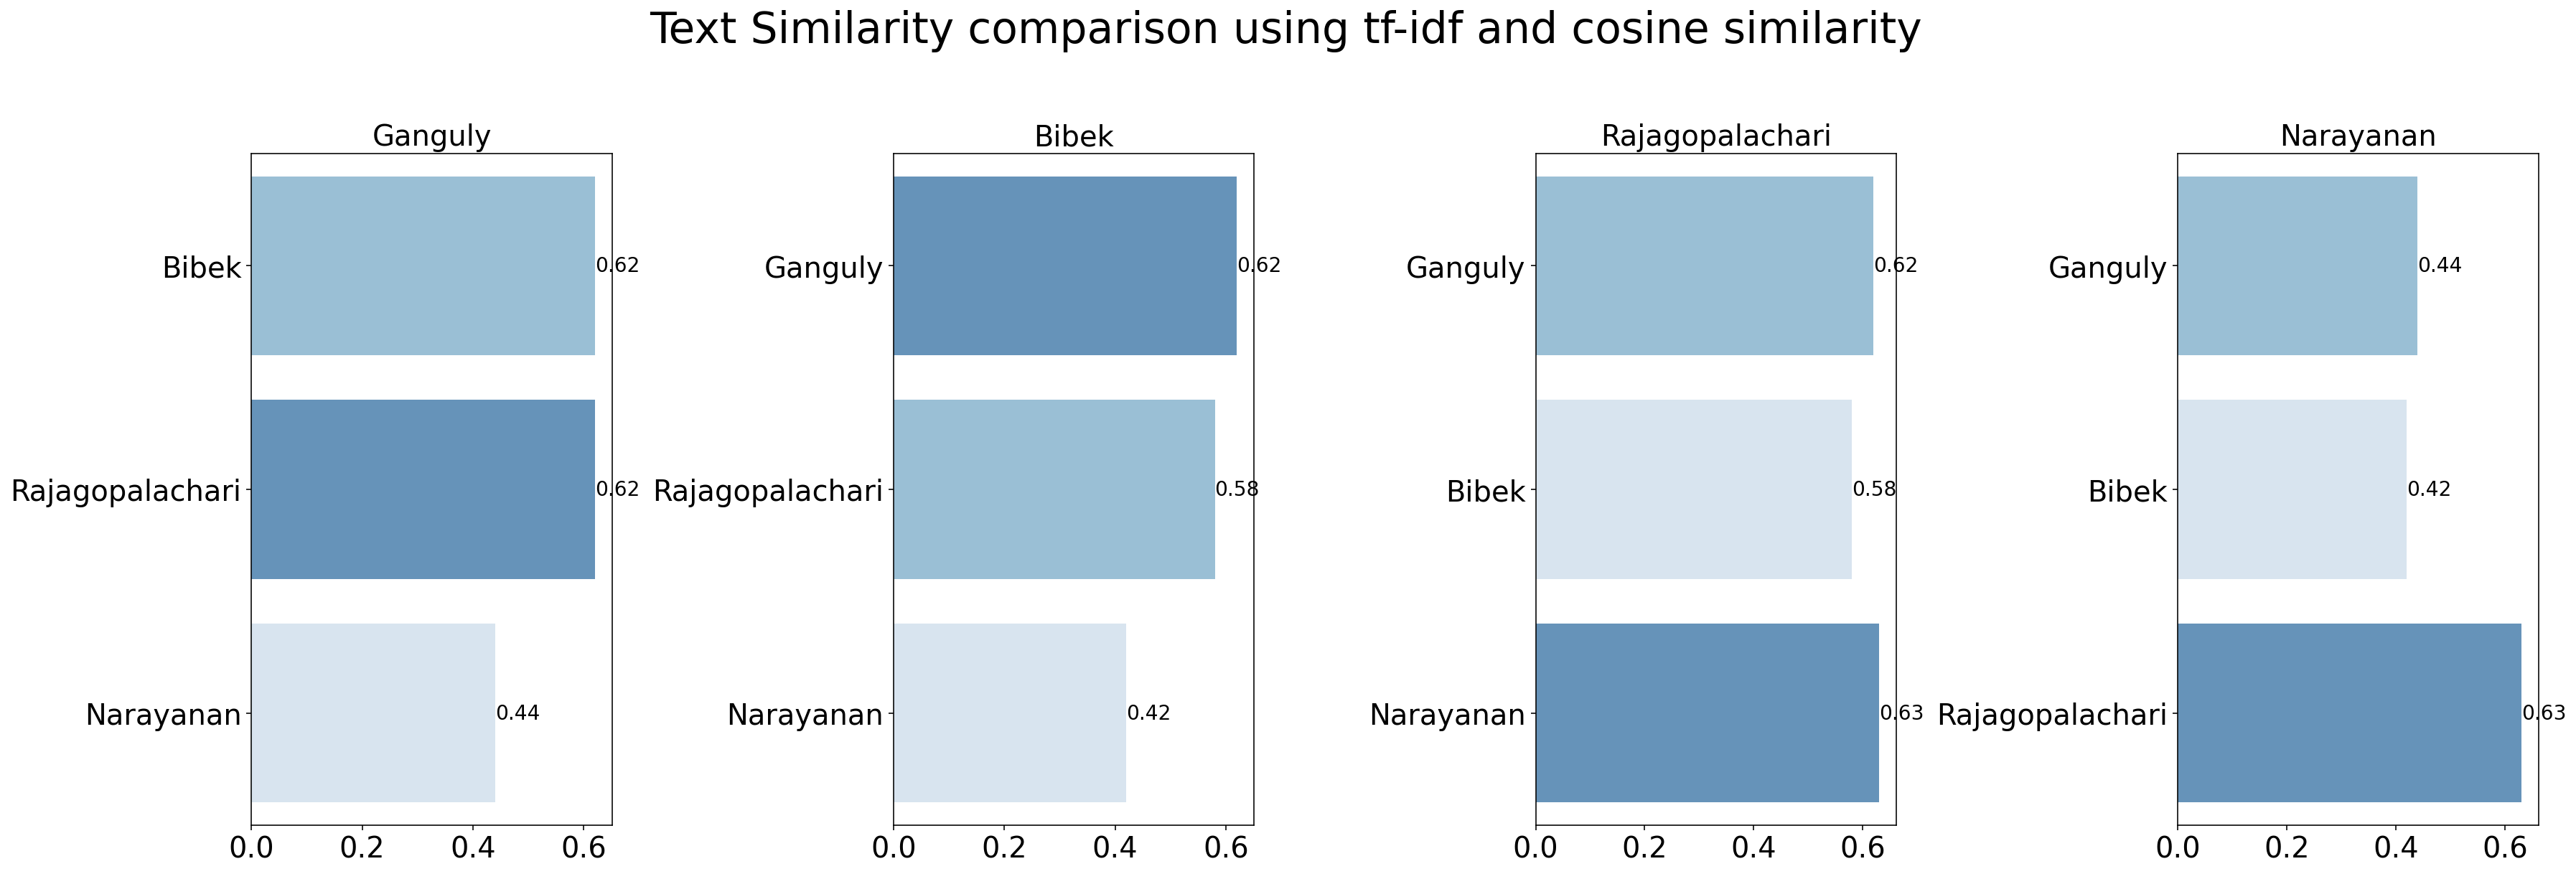

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

In [27]:
def plot_similarity(similarity_matrix):
    """
    This function plots the similarity in a bar chart format 
    Parameters
    ----------
    similarity_matrix : list
          list of similarity values
    """ 
    fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(25, 8))
    ax = axes.flatten()
    fig.suptitle('Text Similarity comparison using tf-idf and cosine similarity', size = 30, y = 1.05 )
    book_names = np.array(['Ganguly', 'Bibek', 'Rajagopalachari', 'Narayanan'])
    for i in range(len(similarity_matrix)):
        ax[i].set_title(f'{book_names[i]}', size = 20)
        plt.figure(figsize = (24, 9))
        indices = list(range(4))
        indices.pop(i)
        vals = similarity_matrix[i][indices]
        rank = vals.argsort().argsort()
        keys = book_names[indices]
        color_palette = np.array(sns.color_palette("Blues", len(vals)))
        g = sns.barplot(y=keys, x=vals, palette = color_palette[rank], alpha = 0.75, ax = ax[i])
        g.bar_label(g.containers[0], labels = vals, size = 14)
        g.set_yticklabels(keys, size = 20)
        g.tick_params(axis='both', which='major', labelsize = 20)

    fig.tight_layout()
    fig.savefig('all_texts_similarity.jpg', )
    fig.show()
plot_similarity(similarity)

#### Let us now find chapterwise similarity between two translations of the Epic
#### Ganguli (FT-1) vs Bibek (FT-2)

In [28]:
# Extract chapters from the Ganguli translation
import os
ganguli_chapters = dict()
ganguli = r"E:\Social Networks and Text Analytics\CA2\Mahabharata\ganguli"
for root, dirs, files in os.walk(ganguli, topdown=False):
    for name in files:
        if '.txt' not in name:
            continue
        t1 = read_file(os.path.join(root, name), remove_stop_words = True, return_type = list)
        index = int(name.split('.')[0])
        ganguli_chapters[index] = t1

In [29]:
# Extract chapters from the Bibek translation
bibek_chapters = dict()
bibek = r"E:\Social Networks and Text Analytics\CA2\Mahabharata\bibek"
for root, dirs, files in os.walk(bibek, topdown=False):
    for name in files:
        if '.txt' not in name:
            continue
        t1 = read_file(os.path.join(root, name), remove_stop_words = True, return_type = list)
        index = int(name.split('.')[0])
        bibek_chapters[index] = t1

In [30]:
def get_cosine_similarity(doc_list):
    """
    This function plots the similarity in a bar chart format 
    Parameters
    ----------
    doc_list : list
          list of documents to compare similarity
    Returns
    -------
    similarity : list
        list of similarity values
    """
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(doc_list)
    similarity = np.round(cosine_similarity(tfidf),2)
    return similarity

In [31]:
# Get Chapterwise Similarity
chapter_wise_similarity = []
for i in range(1, 19):
    a = get_cosine_similarity([' '.join(bibek_chapters[i]), ' '.join(ganguli_chapters[i])])
    chapter_wise_similarity.append(a[0][1])

In [32]:
print(chapter_wise_similarity)

[0.37, 0.5, 0.51, 0.43, 0.43, 0.43, 0.52, 0.58, 0.45, 0.36, 0.38, 0.49, 0.42, 0.43, 0.36, 0.25, 0.26, 0.28]


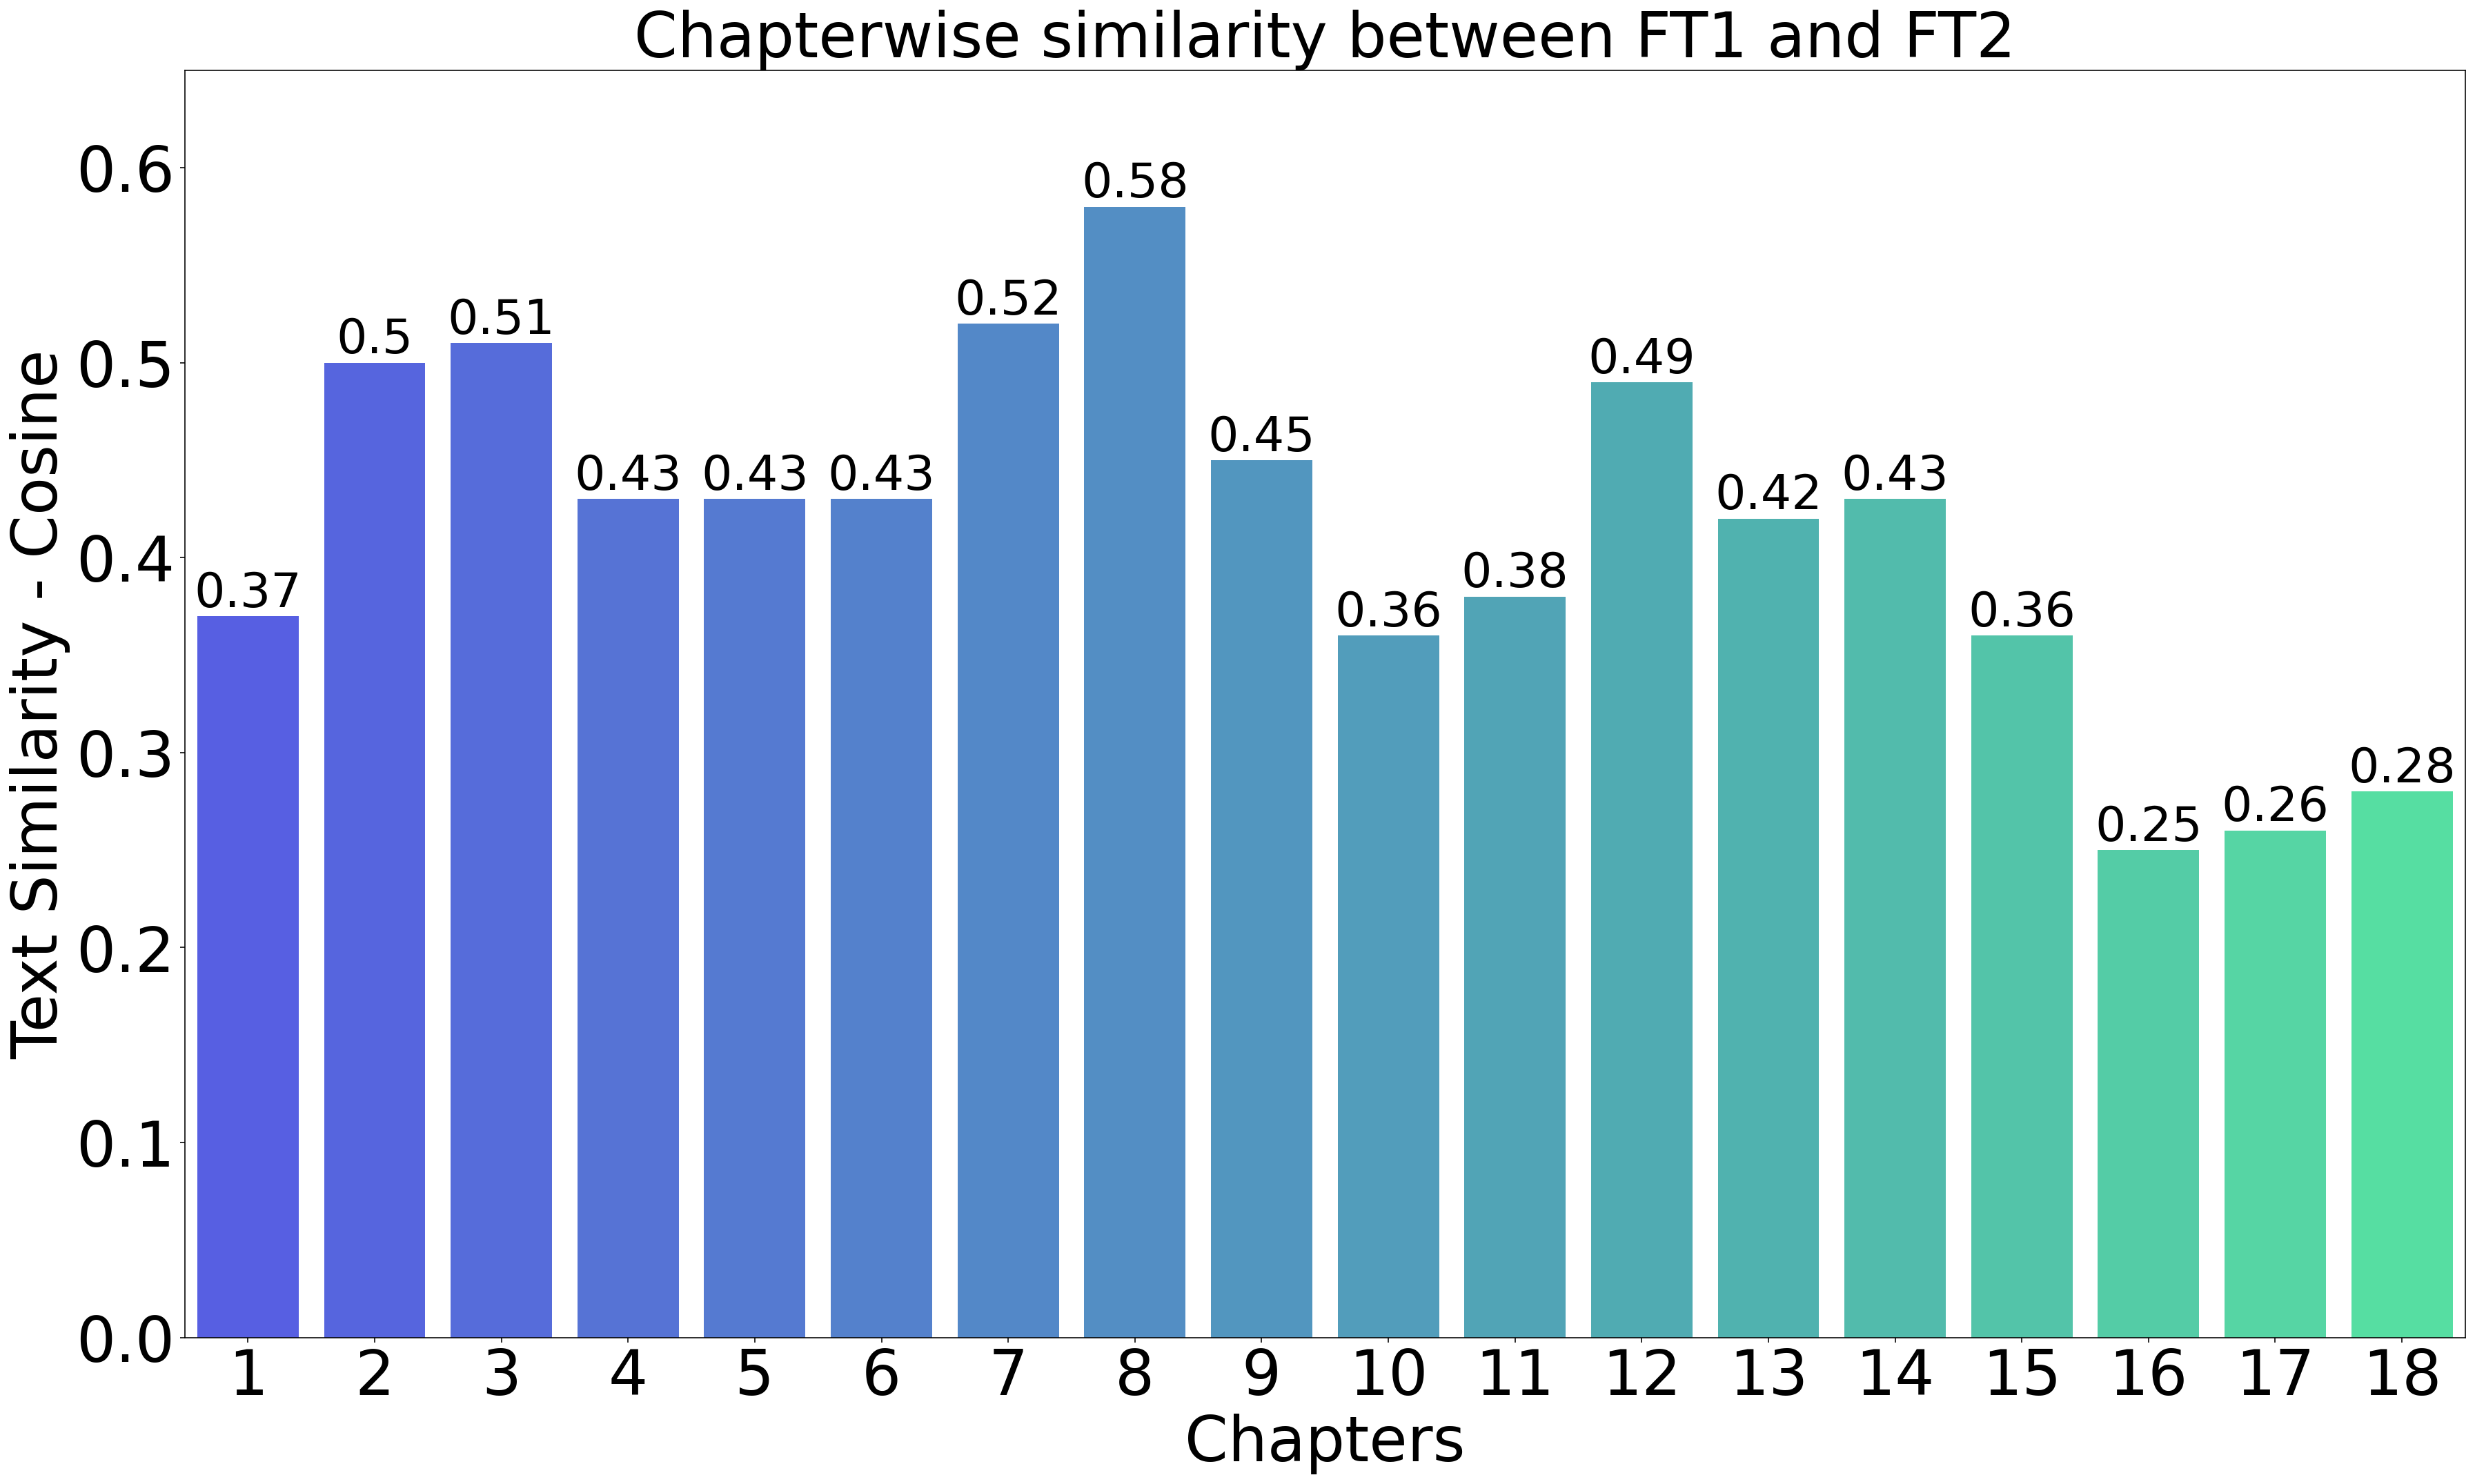

In [33]:
# Plot Chapterwise similarity between the above mentioned two translations
font_size = 45
plt.figure(figsize = (25, 15))
plt.xlabel('Chapters', fontsize = font_size)
plt.ylabel('Text Similarity - Cosine', fontsize = font_size)
plt.xticks(range(1,19))

g = sns.barplot(x= np.arange(1,19), y = chapter_wise_similarity, palette = "winter", color = 'blue', alpha = 0.75)
g.bar_label(g.containers[0], labels = chapter_wise_similarity, size = 35)
g.tick_params(axis='x', which = 'major', labelsize = font_size)
g.tick_params(axis='y', which = 'major', labelsize = font_size)
g.set_title('Chapterwise similarity between FT1 and FT2', fontsize = font_size)
g.set_ylim(0,0.65)
plt.tight_layout()
plt.savefig('Chapterwise-similarity.jpg')

In [34]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
emotion_intensity_file_path = "NRC-Emotion-Intensity-Lexicon.txt"

#### Let us analyse sentiment of each chapter using the NRC Emotion Lexicon Wordlevel

In [35]:
file = "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

def get_word_emotion_lexicon_wordlevel(emotions, emotion_intensity_file_path):
    """
    This function plots the similarity in a bar chart format 
    Parameters
    ----------
    emotions : list
          list of emotions that needs to be extracted from the lexicon
    emotion_intensity_file_path : str
          path to the NRC wordlevel emotion file    
    Returns
    -------
    res : tuple of sets
        Tuple of positive and negative words
    """
    emotion_lexicon = []
    positive = []
    negative = []
    with open(emotion_intensity_file_path) as file:
        for line in file:
            word_int_array = line.replace("\n", "").split("\t")
            if word_int_array[1] == 'negative' and word_int_array[2] == '1':
                negative.append(word_int_array[0])
            elif word_int_array[1] == 'positive' and word_int_array[2] == '1':
                positive.append(word_int_array[0])
    res = (set(positive), set(negative))
    return res

In [36]:
positive_words, negative_words = get_word_emotion_lexicon_wordlevel(emotions, file)

In [37]:
def get_word_sentiment_per_part(text, no_of_parts = 1):
    """
    This function plots the similarity in a bar chart format 
    Parameters
    ----------
    text : list
          list of emotions that needs to be extracted from the lexicon
    no_of_parts : str
          no of parts the text is to be split into.
          This can be useful in case if the text does not 
          have defined chapters
          
    Returns
    -------
    res : tuple of sets
        list that contains positive sentiments and negative sentiments 
        per each chapter
        
    """
    positive_word_count = []
    negative_word_count = []
    total_word_count = []
    for sentence in text:
        pc = 0
        nc = 0
        tc = 0
        for word in sentence.split():
            tc+=1
            lemm_word = lemmatize_word(word)
            if word in positive_words or lemm_word in positive_words:
                pc+=1
            elif word in negative_words or lemm_word in negative_words:
                nc+=1
        if tc == pc or tc == nc:
            continue
        positive_word_count.append(pc)
        negative_word_count.append(nc)
        total_word_count.append(tc)
    pwc_split = np.array_split(np.array(positive_word_count), no_of_parts)
    nwc_split = np.array_split(np.array(negative_word_count), no_of_parts)
    twc_split = np.array_split(np.array(total_word_count), no_of_parts)
    pos_res = []
    neg_res = []
    for i in range(len(pwc_split)):
        pos_res.append(np.sum(pwc_split[i])/np.sum(twc_split[i]) )
        neg_res.append(np.sum(nwc_split[i])/np.sum(twc_split[i]) ) 
    res = pos_res, neg_res
    return res

In [38]:
mb_full_1_list = read_file(file_mb_full_1, preprocess = True, remove_stop_words = False, return_type = list)
mb_full_2_list = read_file(file_mb_full_2, preprocess = True, remove_stop_words = False, return_type = list)
mb_summary_1_list = read_file(file_mb_summary_1, preprocess = True, remove_stop_words = False, return_type = list)
mb_summary_1_list = read_file(file_mb_summary_1, preprocess = True, remove_stop_words = False, return_type = list)

#### Get chapterwise sentiment of Ganguli and Bibek translations 

In [39]:
# Get chapterwise sentiments of Ganguli translation
ganguli_pos_1 = []
ganguli_neg_1 = []
for key, chapter in ganguli_chapters.items():
    a, b = get_word_sentiment_per_part(chapter, no_of_parts = 1)
    ganguli_pos_1.append(a)
    ganguli_neg_1.append(b)

In [40]:
# Get chapterwise sentiments of Bibek translation
bibek_pos_1 = []
bibek_neg_1 = []
for key, chapter in bibek_chapters.items():
    a, b = get_word_sentiment_per_part(chapter, no_of_parts = 1)
    bibek_pos_1.append(a)
    bibek_neg_1.append(b)

In [41]:
ganguli_pos_1 = np.array(ganguli_pos_1).flatten()
ganguli_neg_1 = np.array(ganguli_neg_1).flatten()
bibek_pos_1   = np.array(bibek_pos_1).flatten()
bibek_neg_1   = np.array(bibek_neg_1).flatten()

<ipython-input-42-df851774c5fe>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
<ipython-input-42-df851774c5fe>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )


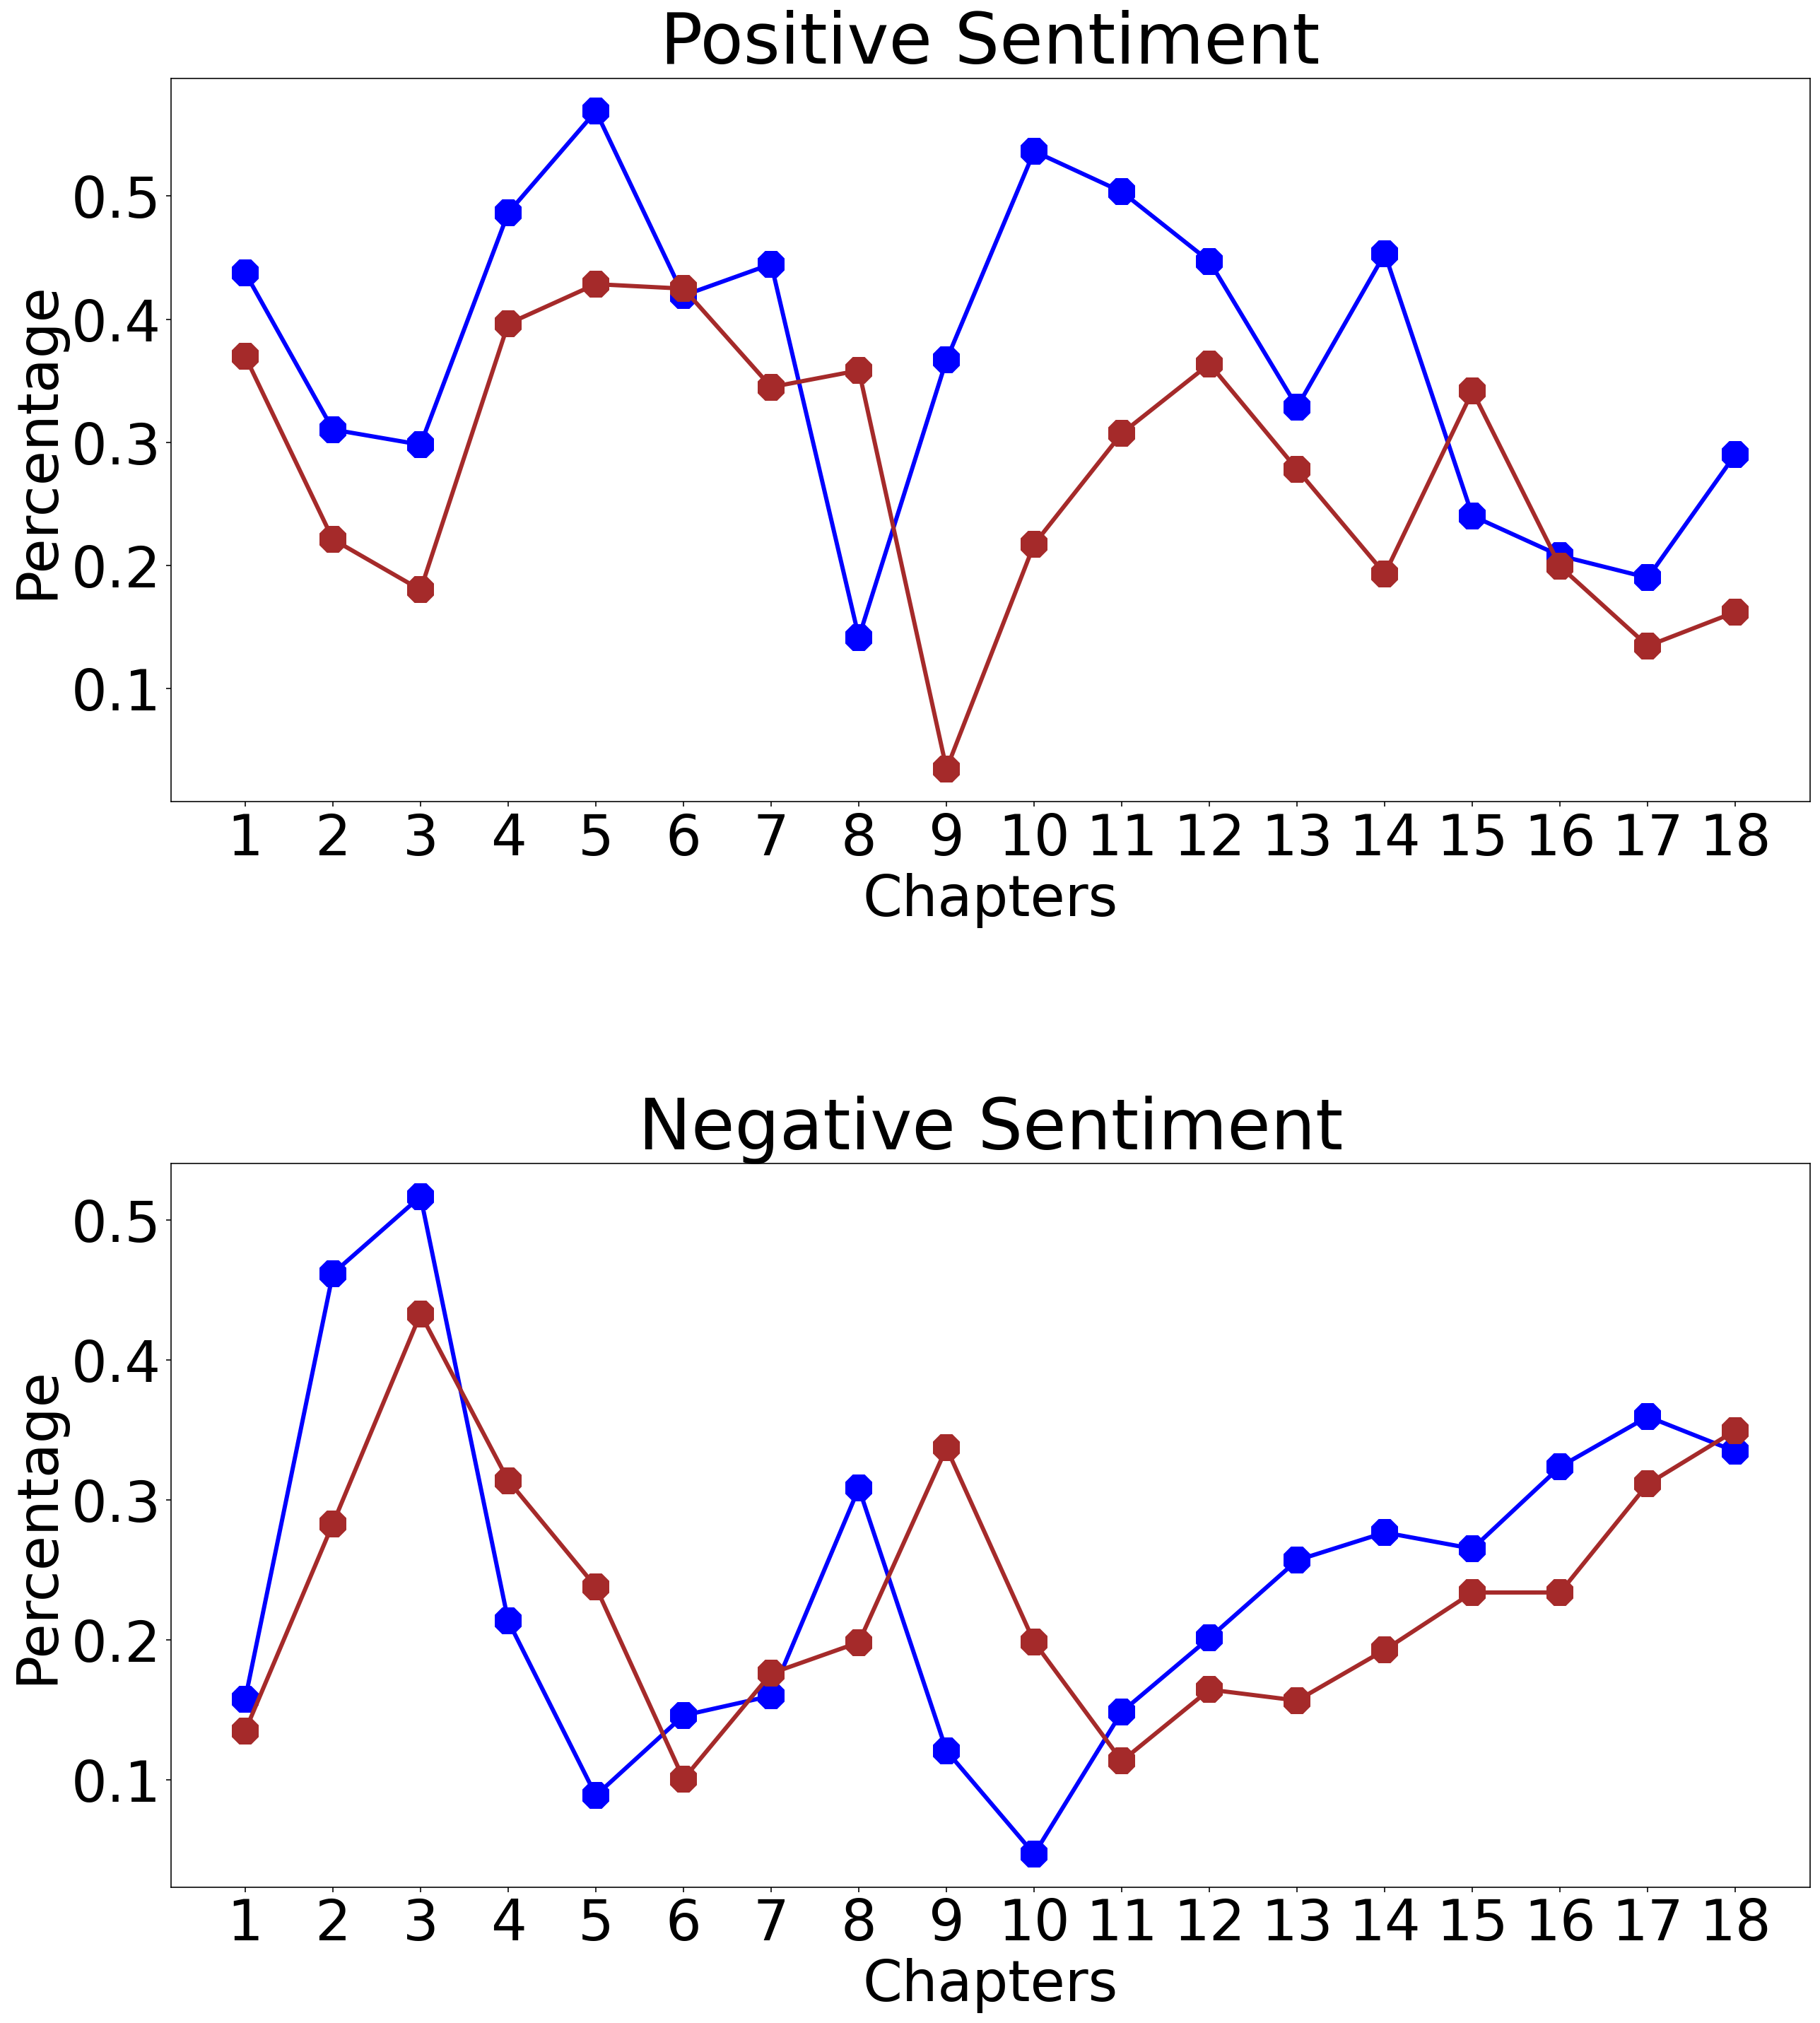

In [42]:
# Plot chapterwise sentiments of both Ganguli and Bibek translations 
# using NRC Emotion Lexicon Wordlevel

font_size = 40
legend_size = 30
title_size = 50
fig, ax = plt.subplots(2, figsize=(18, 20))

axis_index = 0
ax[axis_index].set_title(f'Positive Sentiment', fontsize = title_size)
ax[axis_index].plot(np.arange(1,19), ganguli_pos_1, color = 'blue', marker='8', label = f'FT-1 Positive',  
					linewidth = 3, markersize=20, linestyle = '-')
ax[axis_index].plot(np.arange(1,19), bibek_pos_1, color = 'brown', marker='8', label = f'FT-2 Positive',  
					linewidth = 3, markersize=20, linestyle = '-')

ax[axis_index].set_xticks(np.arange(1,19))
ax[axis_index].set_xticklabels(np.arange(1,19), fontsize = font_size)
ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
ax[axis_index].set_xlabel('Chapters', fontsize = font_size)
ax[axis_index].set_ylabel('Percentage', fontsize = font_size)


axis_index = 1
ax[axis_index].set_title(f'Negative Sentiment', fontsize = title_size)
ax[axis_index].plot(np.arange(1,19), ganguli_neg_1, color = 'blue', marker='8', label = f'FT-1 Positive',  
					linewidth = 3, markersize=20, linestyle = '-')
ax[axis_index].plot(np.arange(1,19), bibek_neg_1, color = 'brown', marker='8', label = f'FT-2 Positive',  
					linewidth = 3, markersize=20, linestyle = '-')

ax[axis_index].set_xticks(np.arange(1,19))
ax[axis_index].set_xticklabels(np.arange(1,19), fontsize = font_size)
ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
ax[axis_index].set_xlabel('Chapters', fontsize = font_size)
ax[axis_index].set_ylabel('Percentage', fontsize = font_size)


plt.tight_layout()
fig.subplots_adjust(hspace=.5)
plt.savefig('Emotion-word-utterance.jpg')

plt.show()

In [44]:
# abcd = get_word_sentiment_per_part(bibek_chapters, no_of_parts = 18)

In [45]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yasas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:
def get_sentiment_scores(text_list):
    """
    This function plots the similarity in a bar chart format 
    Parameters
    ----------
    text_list : list
          List of sentences
          
    Returns
    -------
    res : 
        Returns the normalised VADER sentiment scores
        Scores are normalised by dividing scores per chapter with the 
        no of sentences per chapter
    """
    sentiment_scores_neg = 0.0
    sentiment_scores_pos = 0.0
    sentiment_scores_neu = 0.0
    sentiment_scores_compound = 0.0
    
    for sentence in text_list:
        res = sid.polarity_scores(sentence)
        sentiment_scores_neg += res['neg']
        sentiment_scores_pos += res['pos']
        sentiment_scores_neu += res['neu']
        sentiment_scores_compound += res['compound']
    
    sentiment_scores_neg = round(sentiment_scores_neg * 100 / len(text_list), 3)
    sentiment_scores_pos = round(sentiment_scores_pos * 100 / len(text_list), 3)
    sentiment_scores_neu = round(sentiment_scores_neu * 100 / len(text_list), 3)
    sentiment_scores_compound = round(sentiment_scores_compound * 100 / len(text_list), 3)
    res = sentiment_scores_neg, sentiment_scores_pos, sentiment_scores_neu, sentiment_scores_compound, 
    return res

In [47]:
# Get VADER scores for Ganguli's Translation 
ganguli_scores_neg = []
ganguli_scores_pos = []
ganguli_scores_neu = []
ganguli_scores_compound = []

for ch, text in ganguli_chapters.items():
    a,b,c,d = get_sentiment_scores(text)
    ganguli_scores_neg.append(a)
    ganguli_scores_pos.append(b)
    ganguli_scores_neu.append(c)
    ganguli_scores_compound.append(d)

In [48]:
# Get VADER scores for Bibek's Translation 
bibek_scores_neg = []
bibek_scores_pos = []
bibek_scores_neu = []
bibek_scores_compound = []

for ch, text in bibek_chapters.items():
    a,b,c,d = get_sentiment_scores(text)
    bibek_scores_neg.append(a)
    bibek_scores_pos.append(b)
    bibek_scores_neu.append(c)
    bibek_scores_compound.append(d)

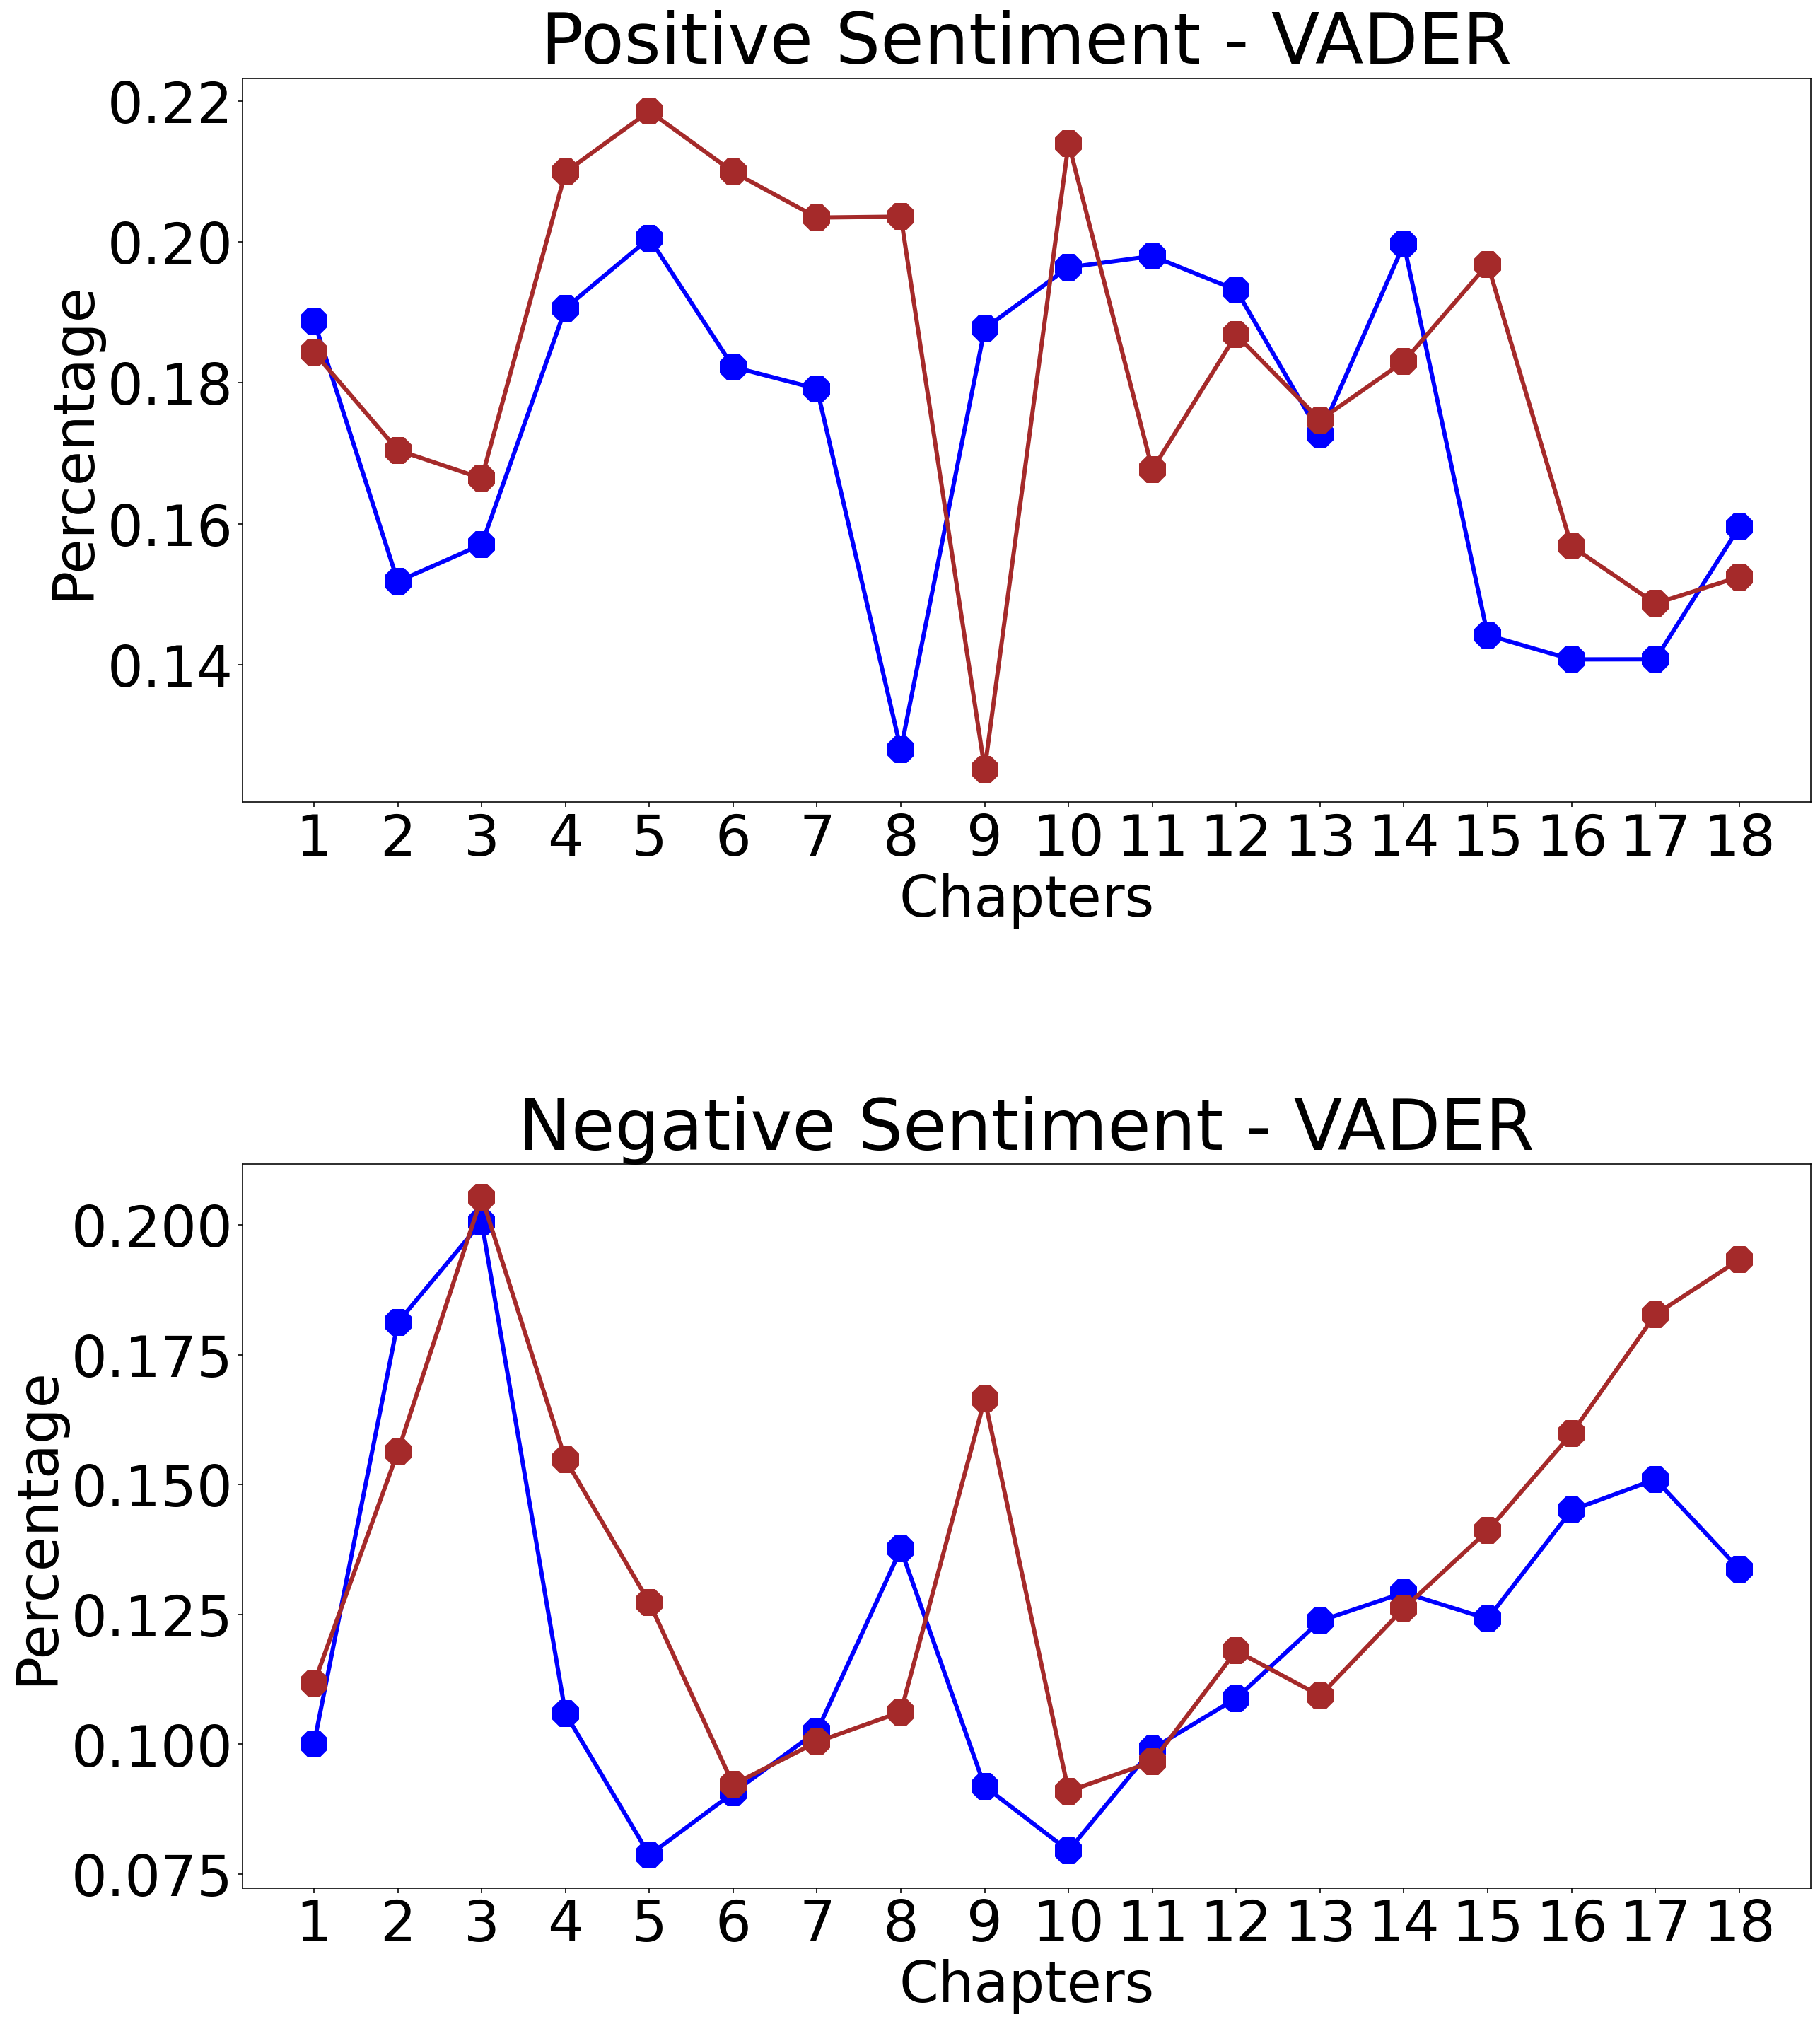

In [49]:
# Plot chapterwise sentiments of both Ganguli and Bibek translations 
# using VADER sentiment scores

font_size = 40
legend_size = 30
title_size = 50
fig, ax = plt.subplots(2, figsize=(18, 20))

axis_index = 0
ax[axis_index].set_title(f'Positive Sentiment - VADER', fontsize = title_size)
ax[axis_index].plot(np.arange(1,19), np.array(ganguli_scores_pos)/100, color = 'blue', marker='8', label = f'FT-1 Positive',  
					linewidth = 3, markersize=20, linestyle = '-')
ax[axis_index].plot(np.arange(1,19), np.array(bibek_scores_pos)/100, color = 'brown', marker='8', label = f'FT-2 Positive',  
					linewidth = 3, markersize=20, linestyle = '-')
ax[axis_index].set_xticks(np.arange(1,19))
ax[axis_index].set_xticklabels(np.arange(1,19), fontsize = font_size)
ax[axis_index].set_xlabel('Chapters', fontsize = font_size)
ax[axis_index].set_ylabel('Percentage', fontsize = font_size)
ax[axis_index].tick_params(axis='both', which='major', labelsize= font_size)

axis_index = 1
ax[axis_index].set_title(f'Negative Sentiment - VADER', fontsize = title_size)
ax[axis_index].plot(np.arange(1,19), np.array(ganguli_scores_neg)/100, color = 'blue', marker='8', label = f'FT-1 Positive',  
					linewidth = 3, markersize=20, linestyle = '-')
ax[axis_index].plot(np.arange(1,19), np.array(bibek_scores_neg)/100, color = 'brown', marker='8', label = f'FT-2 Positive',  
					linewidth = 3, markersize=20, linestyle = '-')

ax[axis_index].set_xticks(np.arange(1,19))
ax[axis_index].set_xticklabels(np.arange(1,19), fontsize = font_size)
ax[axis_index].set_xlabel('Chapters', fontsize = font_size)
ax[axis_index].set_ylabel('Percentage', fontsize = font_size)
ax[axis_index].tick_params(axis='both', which='major', labelsize= font_size)
plt.tight_layout()
fig.subplots_adjust(hspace=.5)
plt.savefig('valer-sentiment.jpg')

plt.show()

In [50]:
def get_word_emotion_intensity_lexicon(emotions, emotion_intensity_file_path):
    emotion_lexicon = []
    word_intensities = {'anger':dict(),
                        'anticipation':dict(),
                        'disgust':dict(),
                        'fear':dict(),
                        'joy':dict(),
                        'sadness':dict(),
                        'surprise':dict(),
                        'trust':dict()}
    with open(emotion_intensity_file_path) as file:
        for line in file:
            word_int_array = line.replace("\n", "").split("\t")
            emotion = word_int_array[1]
            emotion_lexicon.append(word_int_array[0])
            if emotion not in word_intensities.keys():
                continue
            word_intensities[emotion][word_int_array[0]] = float(word_int_array[2])
    return word_intensities, emotion_lexicon

In [51]:
def get_emotion_intensity(text):
    """
    This function extracts the emotion intensities from text  
    Parameters
    ----------
    text : str
          string from which emotion intensities are to be calculated
          
    Returns
    -------
    res : 
        Returns the emotion intensity scoress - actual and normalised
        scores of all emotions calculated using text
    """
    emotions_word_count = np.zeros(shape = (len(emotions)))
    emotions_intensity = np.zeros(shape = (len(emotions)))
    wc = 0
    for word in text.split():
        wc += 1
        lemm_word = lemmatize_word(word)
        if word in emotion_lexicon:
            target = word
        elif lemm_word in emotion_lexicon:
            target = lemm_word
        else:
            continue

        if target in word_intensities['anger'].keys():
                emotions_intensity[0] += word_intensities['anger'][target]
                emotions_word_count[0]+=1

        if target in word_intensities['anticipation'].keys():
                emotions_intensity[1] += word_intensities['anticipation'][target]
                emotions_word_count[1]+=1

        if target in word_intensities['disgust'].keys():
                emotions_intensity[2] += word_intensities['disgust'][target]
                emotions_word_count[2]+=1

        if target in word_intensities['fear'].keys():
                emotions_intensity[3] += word_intensities['fear'][target]
                emotions_word_count[3]+=1

        if target in word_intensities['joy'].keys():
                emotions_intensity[4] += word_intensities['joy'][target]
                emotions_word_count[4]+=1

        if target in word_intensities['sadness'].keys():
                emotions_intensity[5] += word_intensities['sadness'][target]
                emotions_word_count[5]+=1

        if target in word_intensities['surprise'].keys():
                emotions_intensity[6] += word_intensities['surprise'][target]
                emotions_word_count[6]+=1

        if target in word_intensities['trust'].keys():
                emotions_intensity[7] += word_intensities['trust'][target]
                emotions_word_count[7]+=1
    res = emotions_intensity, emotions_intensity / emotions_word_count
    return res

In [52]:
word_intensities, emotion_lexicon = get_word_emotion_intensity_lexicon(emotions, emotion_intensity_file_path)

In [53]:
# Get Emotion Intensity scores of the two full translations of the Epic
res3, res_norm3 = get_emotion_intensity(mb_full_1_str)
res4, res_norm4 = get_emotion_intensity(mb_full_2_str)

### Plot Emotion Intensity scores of full translations of the Epic - Full Translation 1 vs Full Translation 2

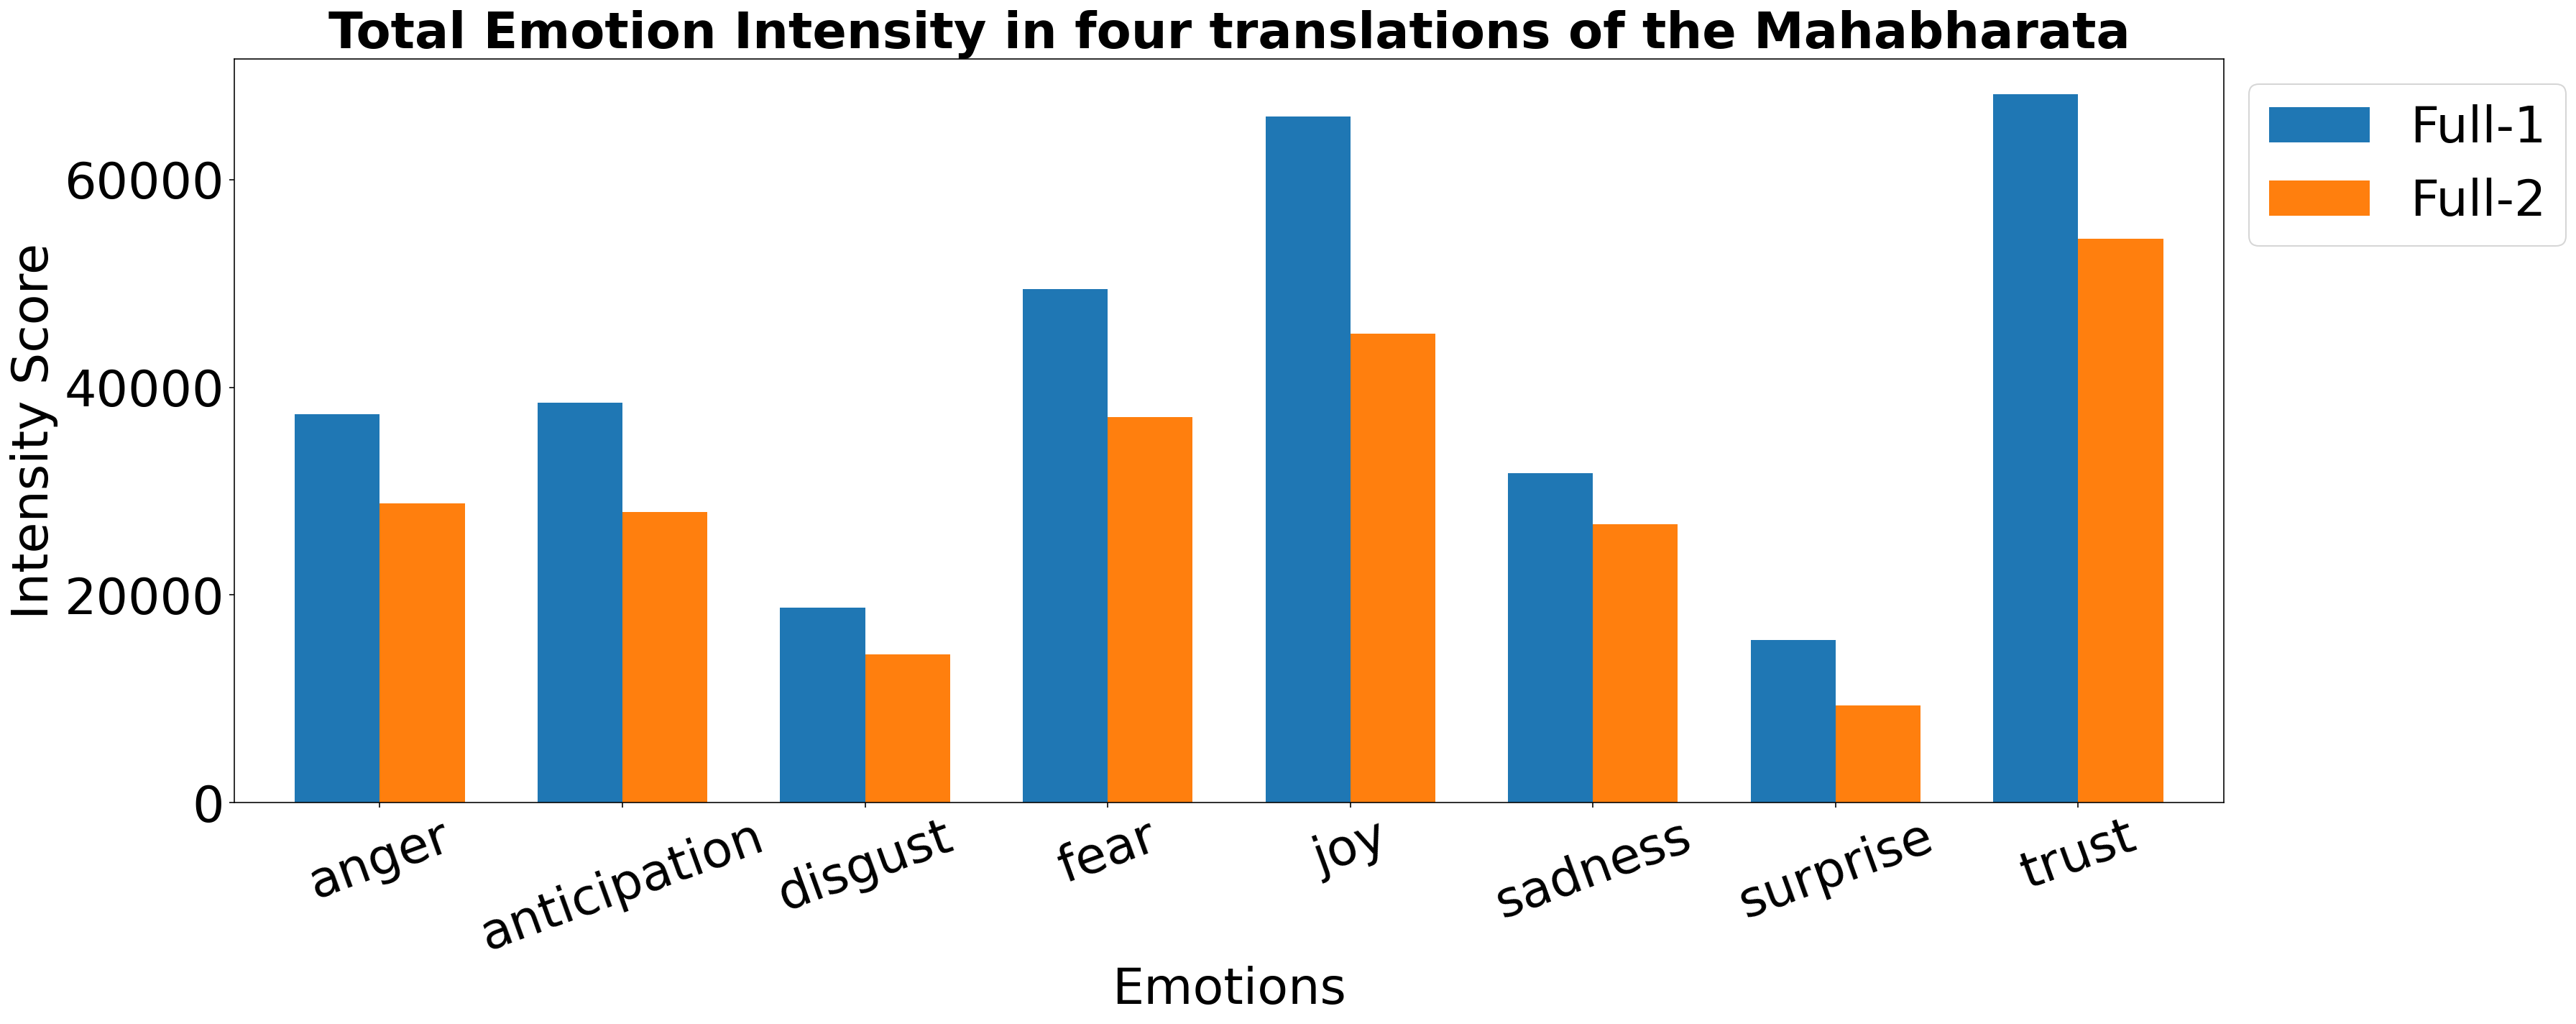

In [54]:
df = pd.DataFrame([res3, res4], 
                  columns = emotions, index = ['Full-1', 'Full-2',]).round(2).T

df['Emotions'] = df.index
font_size = 35
g = df.plot(x = 'Emotions',
        kind = 'bar',
        stacked = False,
        figsize = (25, 10),
        rot = 0,
        fontsize = font_size,
        width = 0.7
       )
legend_properties = {'weight':'bold'}
g.legend(bbox_to_anchor=(1, 1), fontsize = font_size)
plt.xlabel('Emotions' , fontsize = font_size,)
plt.ylabel('Intensity Score', fontsize = font_size, )
g.tick_params(axis='x', which = 'major', labelsize = font_size, rotation = 20)
g.tick_params(axis='y', which = 'major', labelsize = font_size)

plt.title(label = 'Total Emotion Intensity in four translations of the Mahabharata', 
          size = font_size, **{'fontname':'sans-serif', 'fontweight': '649'})
# plt.ylim(0,65)
plt.tight_layout()
plt.savefig('Emotion Intensities.jpg')
plt.show()

In [55]:
def get_emotion_intensity(text):
    """
    This function returns emotion intensities from the text. 
    Parameters
    ----------
    text : str
          string from which emotion intensities are to be calculated
          
    Returns
    -------
    res : 
        Returns the emotion intensity scoress - actual and normalised
        scores of all emotions calculated using text
    """
    emotions_word_count = np.zeros(shape = (len(emotions)))
    emotions_intensity = np.zeros(shape = (len(emotions)))

    wc = 0
    for word in text.split():
        wc += 1
        lemm_word = lemmatize_word(word)
        if word in emotion_lexicon:
            target = word
        elif lemm_word in emotion_lexicon:
            target = lemm_word
        else:
            continue

        if target in word_intensities['anger'].keys():
                emotions_intensity[0] += word_intensities['anger'][target]
                emotions_word_count[0]+=1

        if target in word_intensities['anticipation'].keys():
                emotions_intensity[1] += word_intensities['anticipation'][target]
                emotions_word_count[1]+=1

        if target in word_intensities['disgust'].keys():
                emotions_intensity[2] += word_intensities['disgust'][target]
                emotions_word_count[2]+=1

        if target in word_intensities['fear'].keys():
                emotions_intensity[3] += word_intensities['fear'][target]
                emotions_word_count[3]+=1

        if target in word_intensities['joy'].keys():
                emotions_intensity[4] += word_intensities['joy'][target]
                emotions_word_count[4]+=1

        if target in word_intensities['sadness'].keys():
                emotions_intensity[5] += word_intensities['sadness'][target]
                emotions_word_count[5]+=1

        if target in word_intensities['surprise'].keys():
                emotions_intensity[6] += word_intensities['surprise'][target]
                emotions_word_count[6]+=1

        if target in word_intensities['trust'].keys():
                emotions_intensity[7] += word_intensities['trust'][target]
                emotions_word_count[7]+=1
    res = (emotions_intensity, emotions_intensity / emotions_word_count)
    return res

In [56]:
def get_chapterwise_emotion_intensities(text_chapterwise):
    """
    This function returns chapterwise intensities the similarity in a bar chart format 
    Parameters
    ----------
    text : str
          string from which emotion intensities are to be calculated
          
    Returns
    -------
    res : 
        Returns the emotion intensity scoress - actual and normalised
        scores of all emotions calculated using text
    """
    res = []
    for i in range(1, 19):
        a = get_emotion_intensity(' '.join(text_chapterwise[i]))[1]
        res.append(a)
    return res

def extract_emotion_intensity(chapterwise_emotions, emotion):
    """
    This function plots the similarity in a bar chart format 
    Parameters
    ----------
    text : str
          string from which emotion intensities are to be calculated
          
    Returns
    -------
    res : 
        Returns the emotion intensity scoress - actual and normalised
        scores of all emotions calculated using text
    """
    index = {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}
    res = []
    for emotion_list in chapterwise_emotions:
        res.append(emotion_list[index[emotion]])
    return np.array(res)

In [57]:
ganguli_chapterwise_emotions = get_chapterwise_emotion_intensities(ganguli_chapters)

In [58]:
bibek_chapterwise_emotions = get_chapterwise_emotion_intensities(bibek_chapters)

### Chapterwise Emotion Intensity of Anger, Disgust, Fear and Sadness 

<ipython-input-60-56a6fdb1e5c6>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
<ipython-input-60-56a6fdb1e5c6>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
<ipython-input-60-56a6fdb1e5c6>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
<ipython-input-60-56a6fdb1e5c6>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )


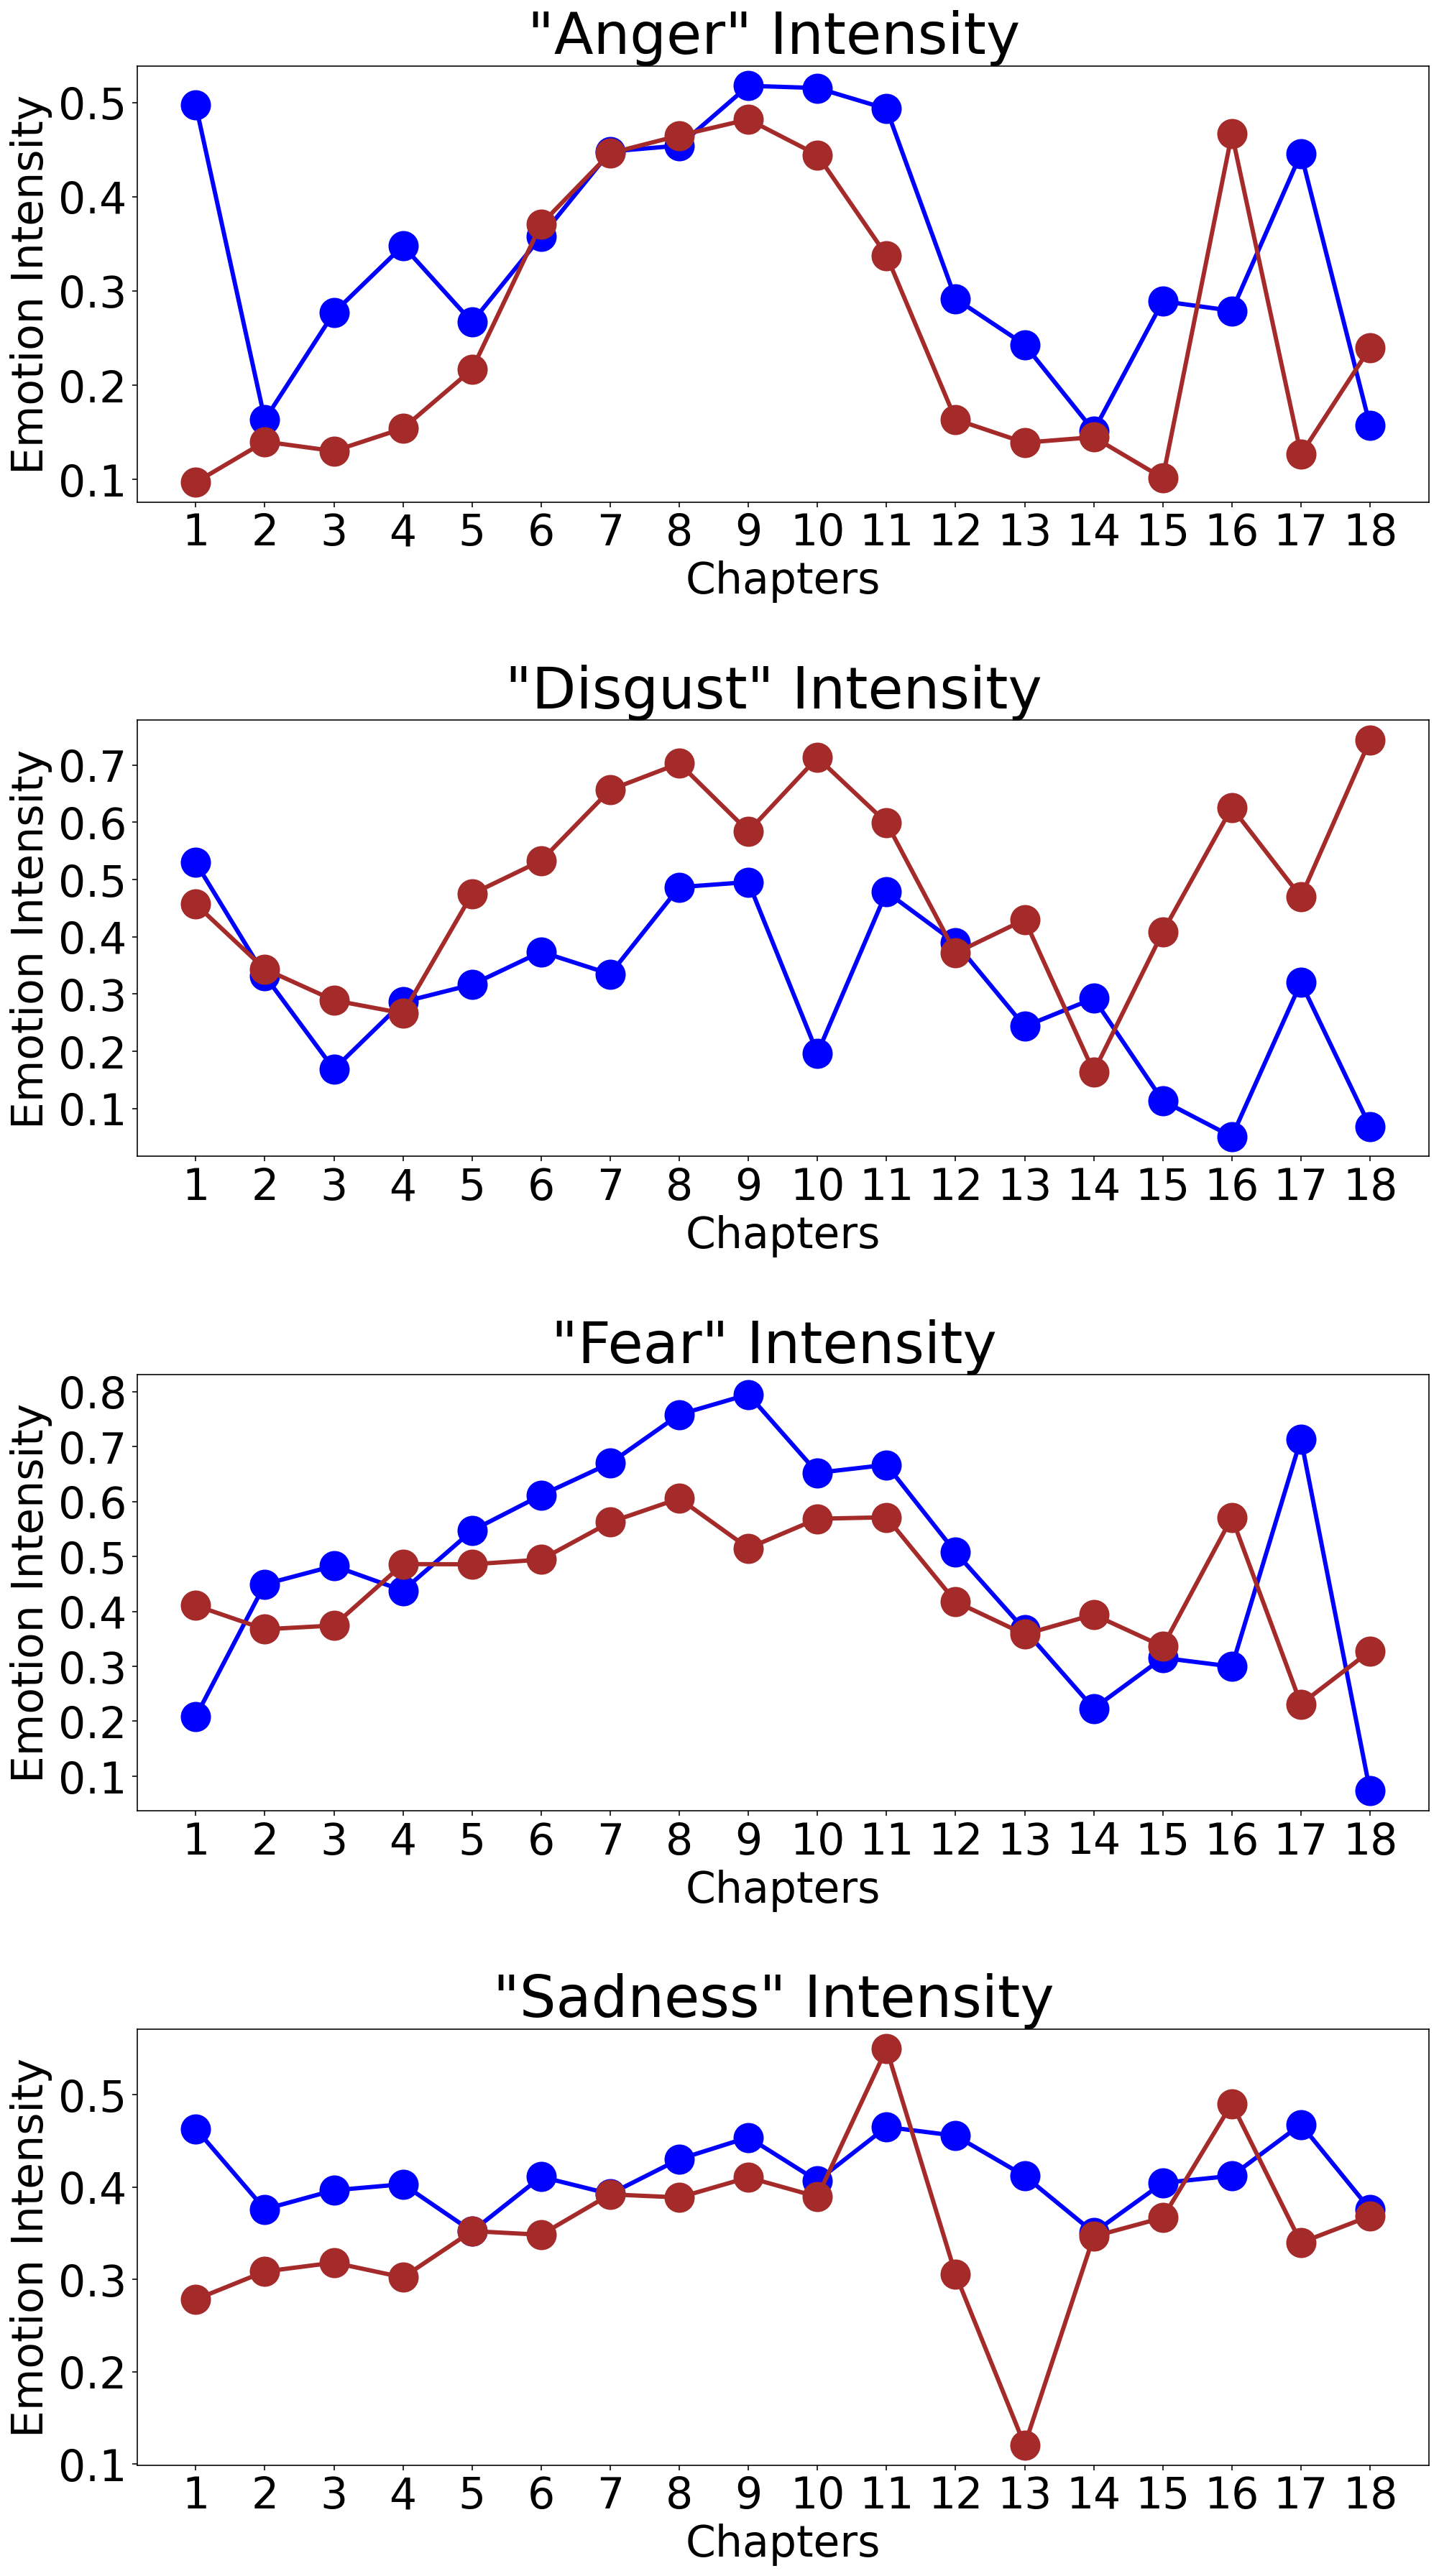

In [60]:
# plt.figure(figsize=(6, 4))
font_size = 30
legend_size = 30
title_size = 40
fig, ax = plt.subplots(4, figsize=(14, 25))

axis_index = 0

axes = [0, 2, 3, 5] # index positions of Anger, Disgust, Fear and Sadness 
for axis_index, i, in enumerate(axes):
    text1 = extract_emotion_intensity(ganguli_chapterwise_emotions, emotions[i])
    text2 = extract_emotion_intensity(bibek_chapterwise_emotions, emotions[i])
    ax[axis_index].plot(np.arange(1,19), text2, color = 'blue', marker='o', label = f'FT1-{emotions[i]}',  linewidth =3, 
                    markersize=20, linestyle = '-')
    ax[axis_index].plot(np.arange(1,19), text1, color = 'brown', marker='o', label = f'FT1-{emotions[i]}',  linewidth =3, 
                    markersize=20, linestyle = '-')
    ax[axis_index].set_title(f'"{emotions[i].title()}" Intensity ', fontsize = title_size)
    ax[axis_index].set_xticks(np.arange(1,19))
    ax[axis_index].set_xticklabels(np.arange(1,19), fontsize = font_size)
    ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
    ax[axis_index].set_xlabel('Chapters', fontsize = font_size)
    ax[axis_index].set_ylabel('Emotion Intensity', fontsize = font_size)
    # legend = ax[axis_index].legend(loc='best', shadow=True, fontsize = legend_size)


plt.tight_layout()
fig.subplots_adjust(hspace=.5)
plt.savefig('negative_emotions.jpg')

plt.show()

### Chapterwise Emotion Intensity of Anticipation, Joy, Surprise and Trust 

<ipython-input-61-927b2cae210f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
<ipython-input-61-927b2cae210f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
<ipython-input-61-927b2cae210f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
<ipython-input-61-927b2cae210f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )


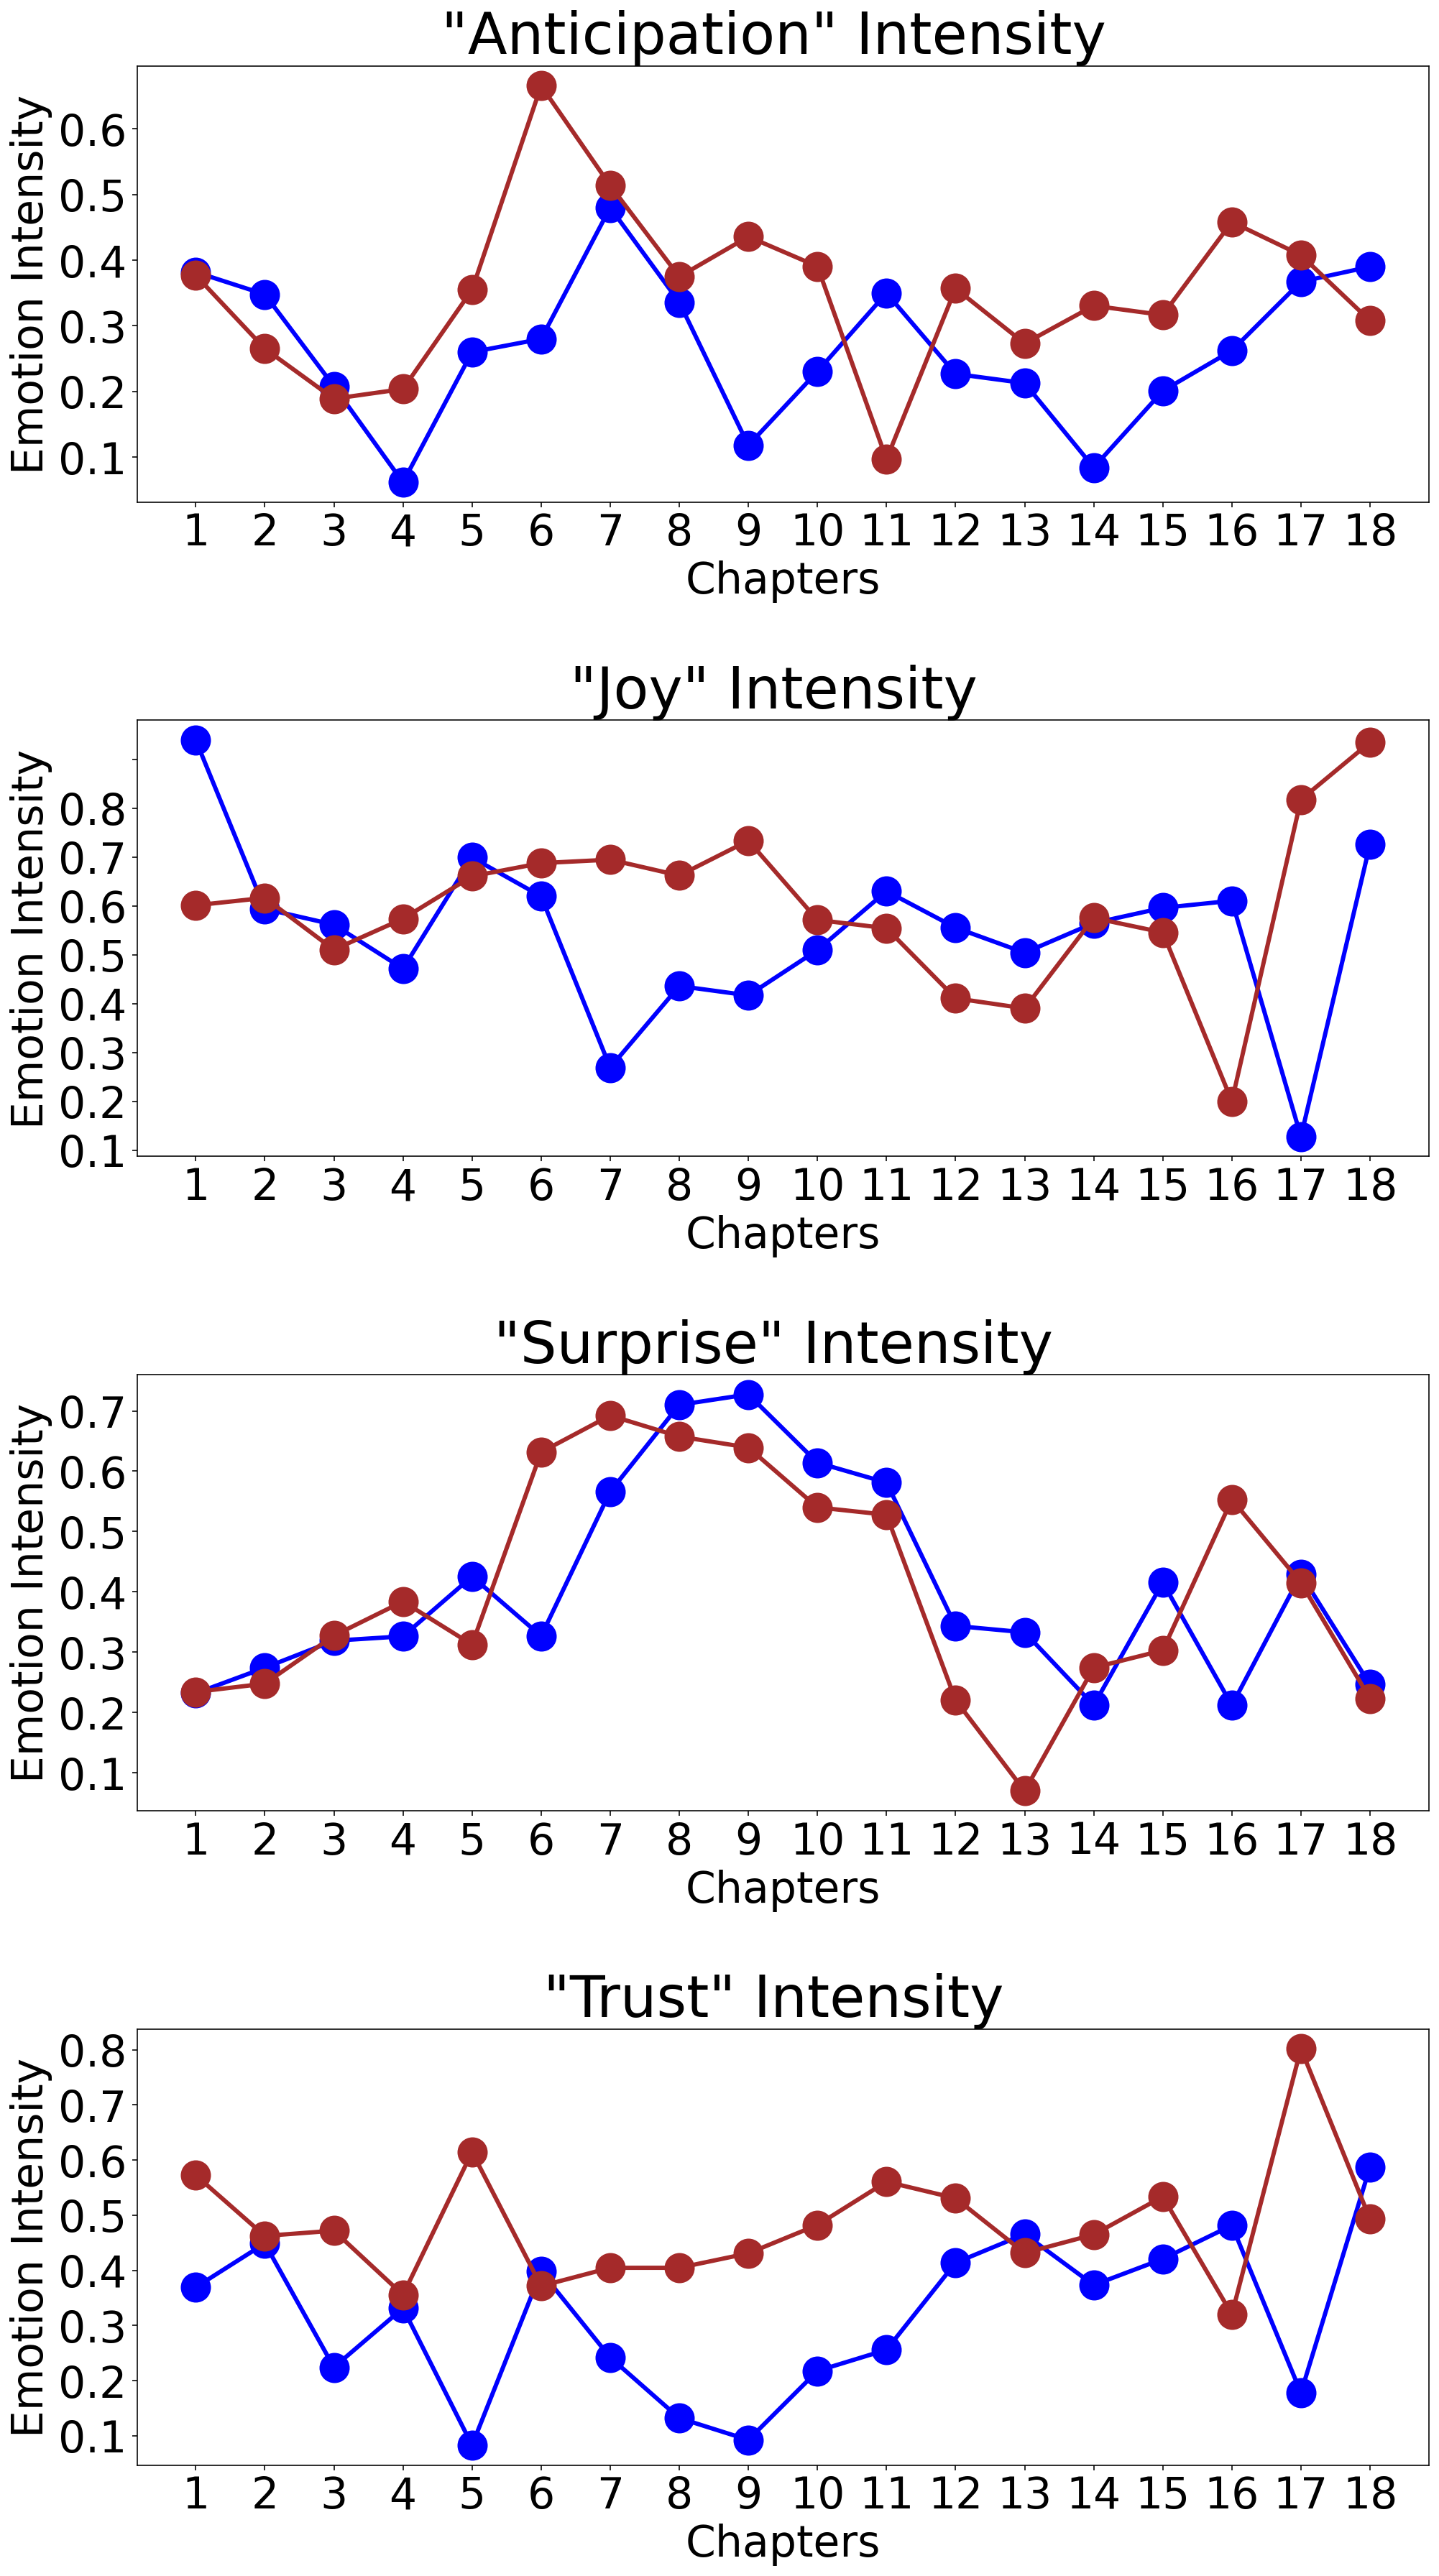

In [61]:
# plt.figure(figsize=(6, 4))
font_size = 30
legend_size = 30
title_size = 40
fig, ax = plt.subplots(4, figsize=(14, 25))

axis_index = 0

a = [1, 4, 6, 7] # index positions of anticipation, joy, surprise and trust
for axis_index, i, in enumerate(a):
    text2 = extract_emotion_intensity(bibek_chapterwise_emotions, emotions[i])
    text1 = extract_emotion_intensity(ganguli_chapterwise_emotions, emotions[i])
    ax[axis_index].plot(np.arange(1,19), text2, color = 'blue', marker='o', label = f'FT1-{emotions[i]}',  linewidth =3, 
                    markersize=20, linestyle = '-')
    ax[axis_index].plot(np.arange(1,19), text1, color = 'brown', marker='o', label = f'FT1-{emotions[i]}',  linewidth =3, 
                    markersize=20, linestyle = '-')
    ax[axis_index].set_title(f'"{emotions[i].title()}" Intensity ', fontsize = title_size)
    ax[axis_index].set_xticks(np.arange(1,19))
    ax[axis_index].set_xticklabels(np.arange(1,19), fontsize = font_size)
    ax[axis_index].set_yticklabels(np.arange(0.0, 0.9, 0.1, dtype = np.float32), fontsize = font_size, )
    ax[axis_index].set_xlabel('Chapters', fontsize = font_size)
    ax[axis_index].set_ylabel('Emotion Intensity', fontsize = font_size)
  # legend = ax[axis_index].legend(loc='best', shadow=True, fontsize = legend_size)


plt.tight_layout()
fig.subplots_adjust(hspace=.5)
plt.savefig('positive_emotions.jpg')

plt.show()